In [31]:
import os
import subprocess
from concurrent.futures import ThreadPoolExecutor
from io import StringIO
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

SCHEDVIEW = "./build/schedview/schedview"
PLATFORM = "./platforms/exynos5422LITTLE.json"

def linspace_to_intervals(start, stop, num, endpoint=True):
    points = np.linspace(start, stop, num, endpoint=endpoint)
    return list(zip(points[:-1], points[1:]))

def numbers_to_interval_dataframe(numbers, intervals):
    interval_list = [f"{start}-{end}" for start, end in intervals]
    df = pl.DataFrame({
        "interval": interval_list,
        "count": [0] * len(intervals)
    })
    
    for num in numbers:
        for i, (start, end) in enumerate(intervals):
            if start <= num < end:
                df = df.with_columns(
                    pl.when(pl.col("interval") == interval_list[i])
                    .then(pl.col("count") + 1)
                    .otherwise(pl.col("count"))
                    .alias("count")
                )
                break
    return df

def call_cmpt(log, index):
    args = [SCHEDVIEW, "--platform", PLATFORM, log, "--config"]
    if index:
        args.append("--index")
    return subprocess.run(args, capture_output=True, text=True, check=True).stdout

def convert_to_bins(path, bins):
    res = pl.read_csv(StringIO(call_cmpt(path, True)), separator=";").with_columns((pl.col("stop") - pl.col("start")).alias("duration"))
    return numbers_to_interval_dataframe(res["duration"].to_list(), bins)["count"].to_list()

def list_operation(list1, list2, op):
    if len(list1) != len(list2):
        raise ValueError("Lists must be of the same length")
    return [op(a, b) for a, b in zip(list1, list2)]

def normalize(data):
    max_value = max(max(data), abs(min(data)))
    normalized = []
    for value in data:
        if value > 0:
            normalized.append(value / max_value if max_value != 0 else 0)
        elif value < 0:
            normalized.append(-abs(value) / abs(max_value) if max_value != 0 else 0)
        else:
            normalized.append(0)
    
    return normalized


def plot_histogram_from_intervals(intervals, counts, ax, title):
    bins = [start for start, _ in intervals] + [intervals[-1][1]]
    centers = [(start + end) / 2 for start, end in intervals]
    
    ax.hist(centers, bins=bins, weights=counts, edgecolor='black')
    
    ax.set_xlabel('Intervals')
    ax.set_ylabel('Count')
    ax.set_title(f'Histogram from Interval Data - {title}')
    ax.set_xticks(bins[:-1] + np.diff(bins)/2, [f'{int(start)}-{int(end)}' for start, end in intervals])

def compute(util, suffix):
    bins = linspace_to_intervals(0, 20000, 4001)
    
    logsdirs = {
        "pa": f"data_umax0_9_logs_pa_no_delay/{util}/",
        "ffa": f"data_umax0_9_logs_ffa_{suffix}/{util}/",
        "csf": f"data_umax0_9_logs_csf_{suffix}/{util}/"
    }

    diffs = {
        "ffa": [0] * len(bins),
        "csf": [0] * len(bins)
    }

    with ThreadPoolExecutor() as executor:
        futures = []
        for file in sorted(os.listdir(logsdirs["pa"])):
            futures.append(executor.submit(convert_to_bins, f"{logsdirs['pa']}{file}", bins))
            futures.append(executor.submit(convert_to_bins, f"{logsdirs['ffa']}{file}", bins))
            futures.append(executor.submit(convert_to_bins, f"{logsdirs['csf']}{file}", bins))

        for i, file in enumerate(sorted(os.listdir(logsdirs["pa"]))):
            pa, ffa, csf = [future.result() for future in futures[i*3:(i+1)*3]]
            diffs["ffa"] = list_operation(diffs["ffa"], normalize(list_operation(csf, pa, lambda x, y: x - y)), lambda x, y: x + y)
            diffs["csf"] = list_operation(diffs["csf"], normalize(list_operation(csf, pa, lambda x, y: x - y)), lambda x, y: x + y)

    diffs["ffa"] = normalize(diffs["ffa"])
    diffs["csf"] = normalize(diffs["csf"])

    csv_data = pl.DataFrame({
        "start": [start for start, _ in bins],
        "FFA": diffs["ffa"],
        "CSF": diffs["csf"]
    }, strict=False)
    csv_filename = f"histogram-config-{suffix}.csv"
    csv_data.write_csv(csv_filename, separator=';')
    
    # Plotting both FFA and CSF histograms side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    # FFA plot
    plot_histogram_from_intervals(bins, diffs["ffa"], ax1, "FFA")
    
    # CSF plot
    plot_histogram_from_intervals(bins, diffs["csf"], ax2, "CSF")

    plt.tight_layout()
    plt.show()

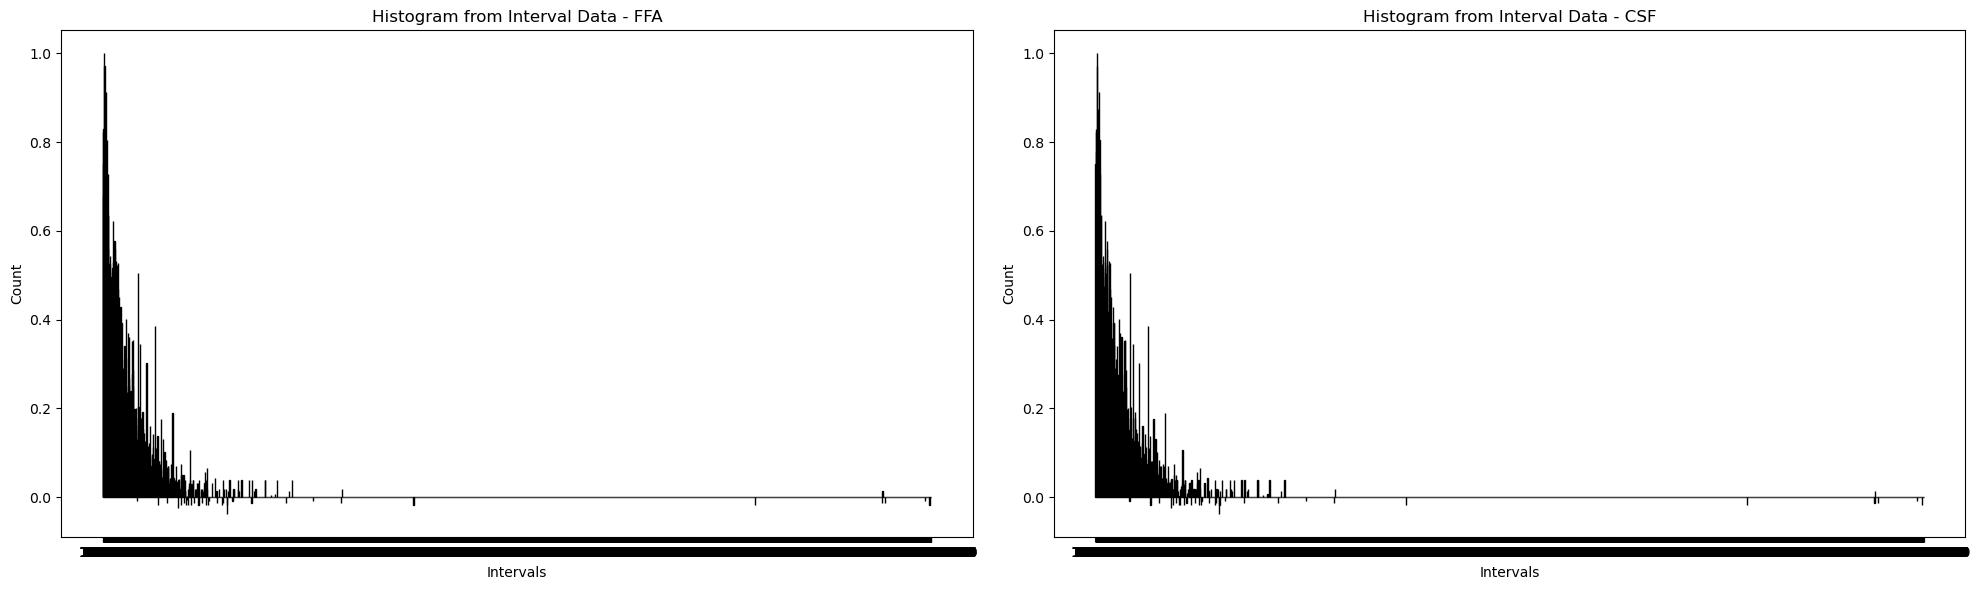

In [32]:
compute("util_4_0", "no_delay")

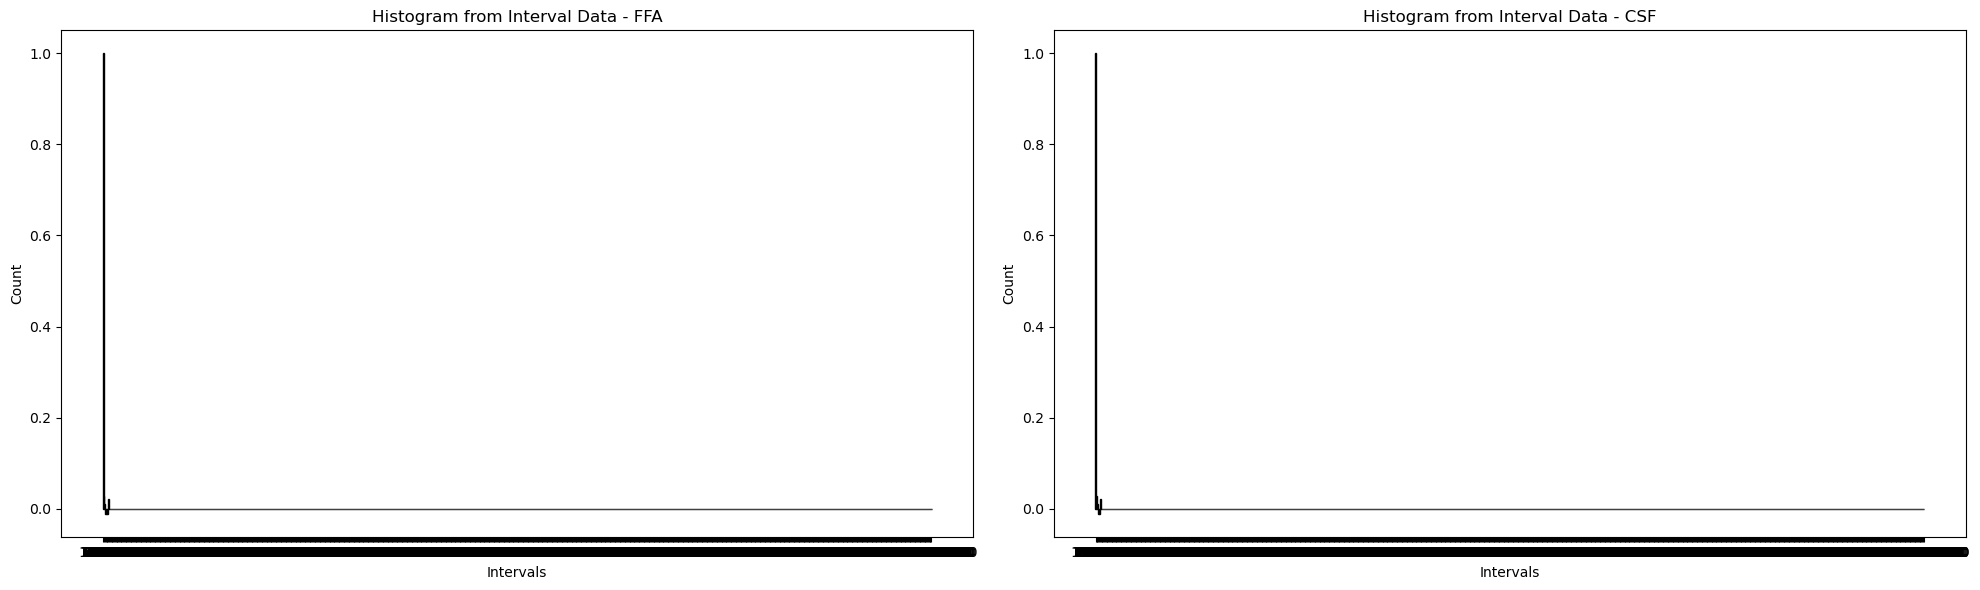

In [85]:
compute("util_0_1")

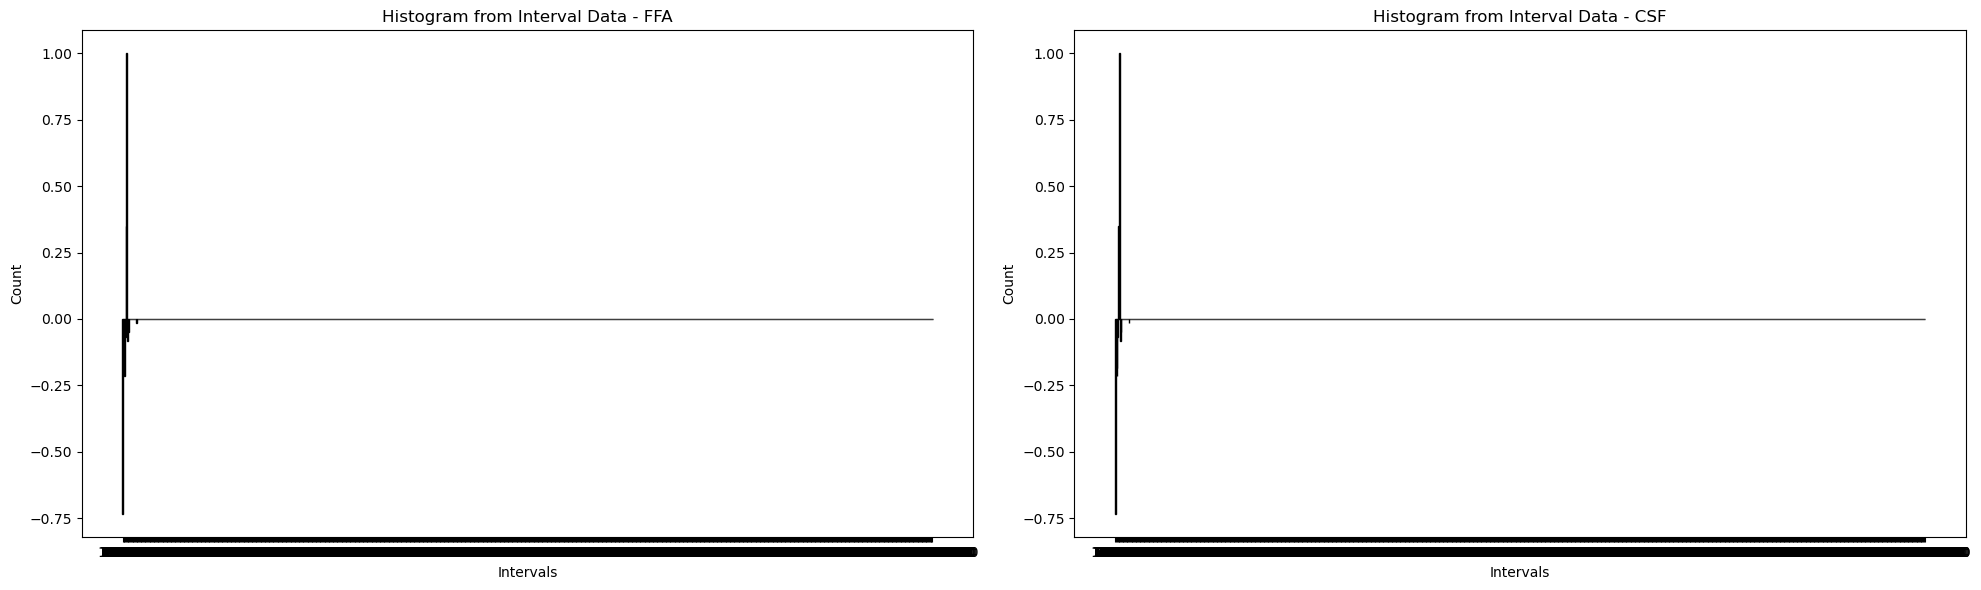

In [44]:
compute("util_0_2")

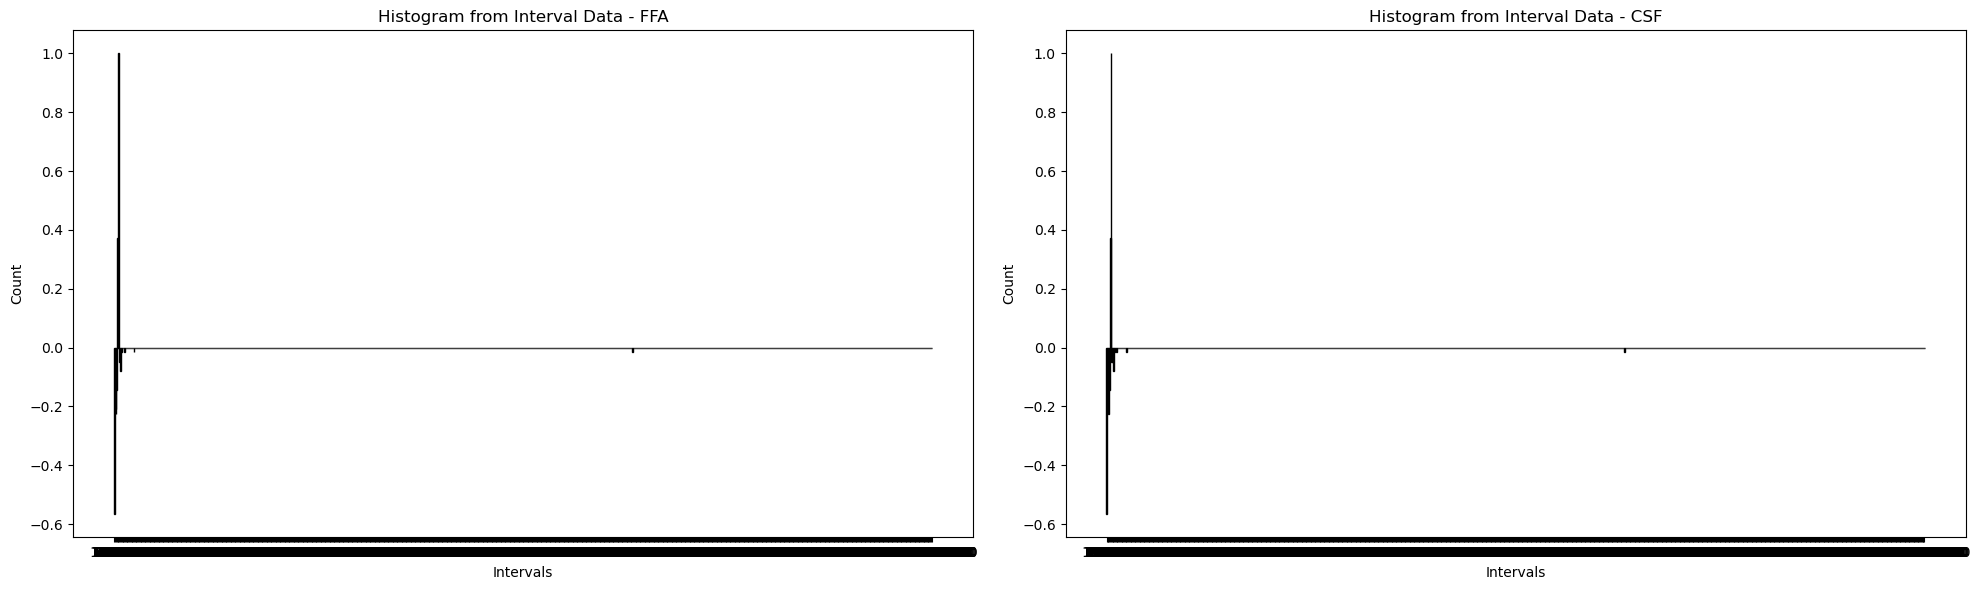

In [45]:
compute("util_0_3")

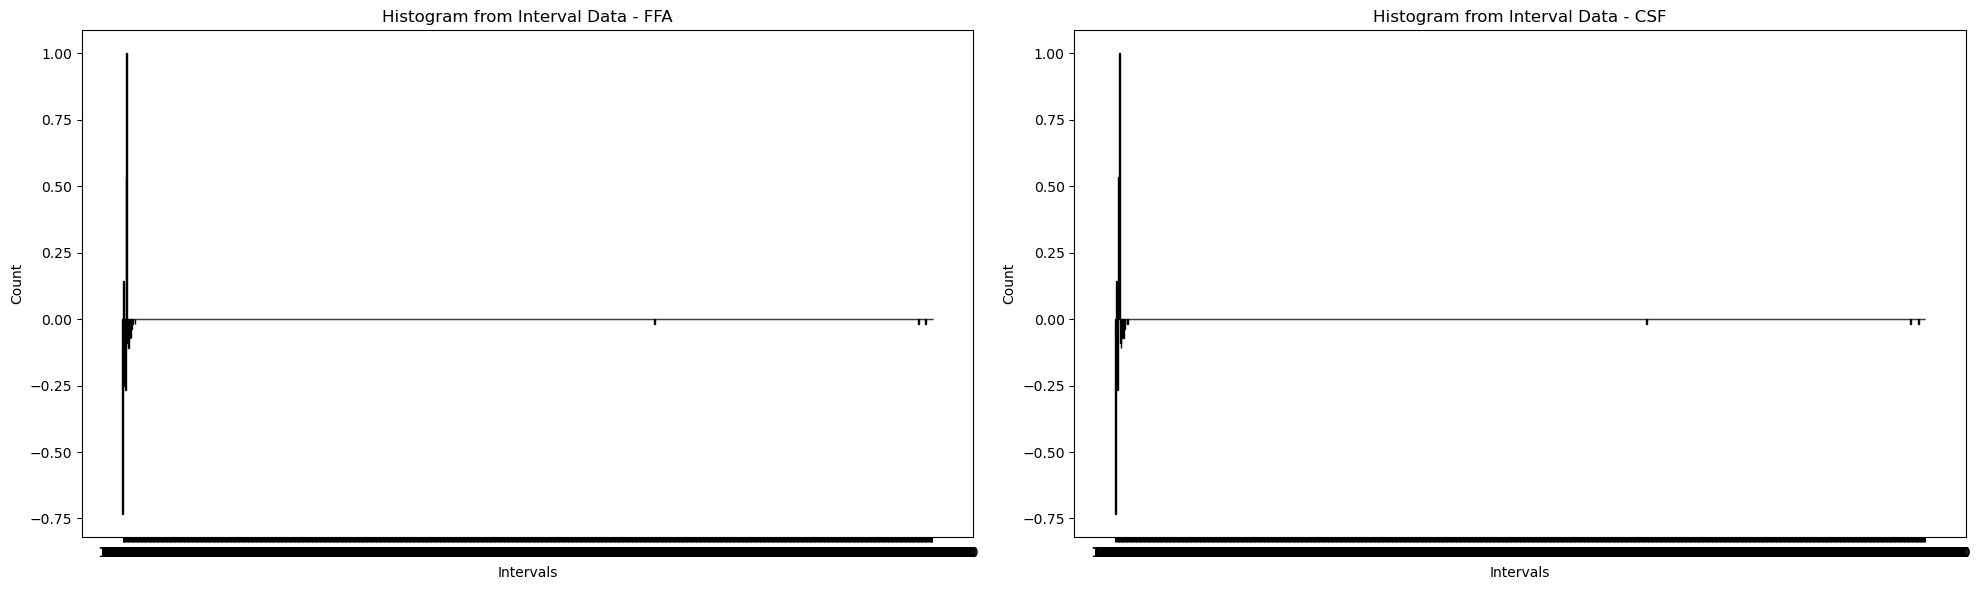

In [46]:
compute("util_0_4")

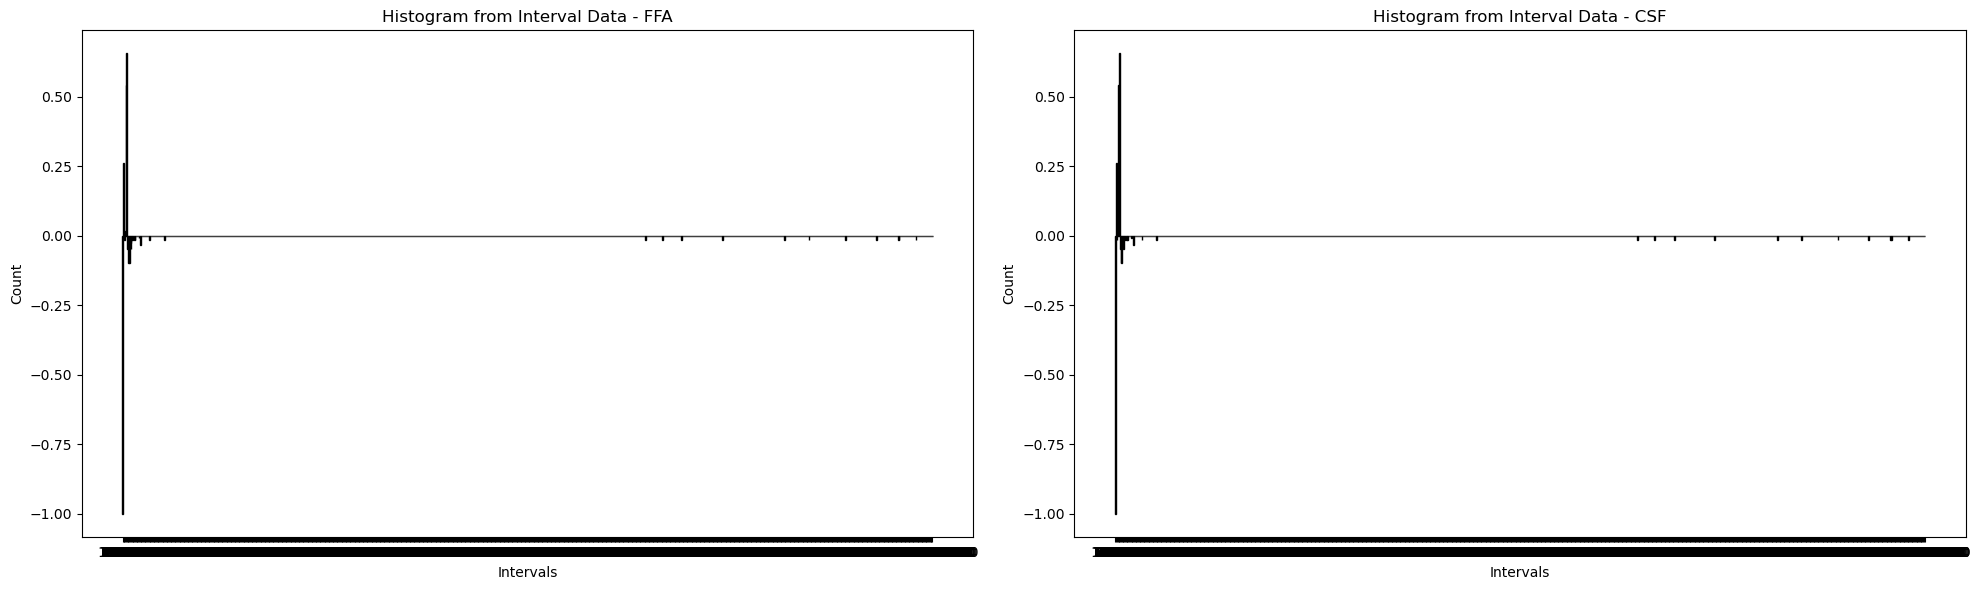

In [47]:
compute("util_0_5")

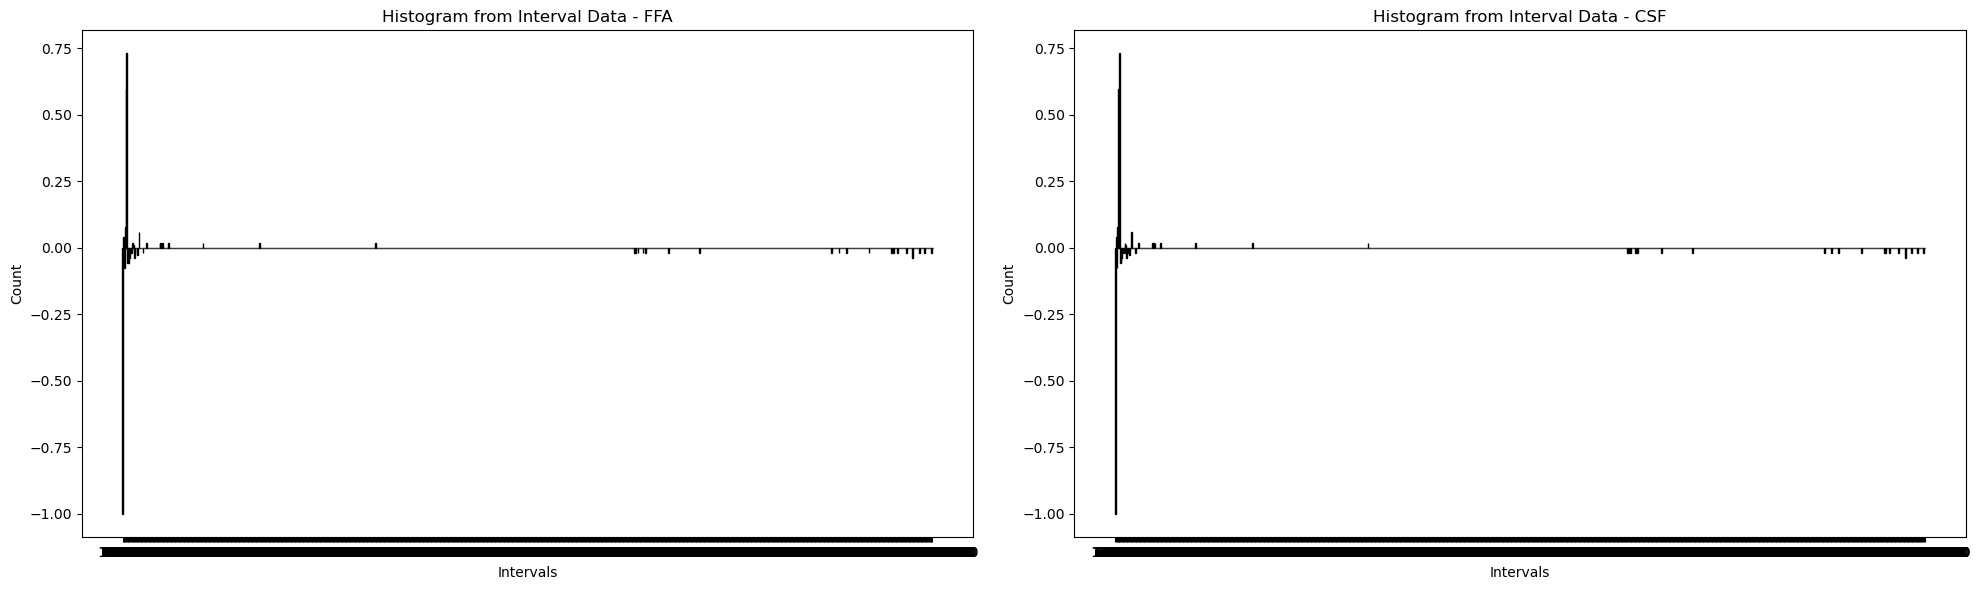

In [48]:
compute("util_0_6")

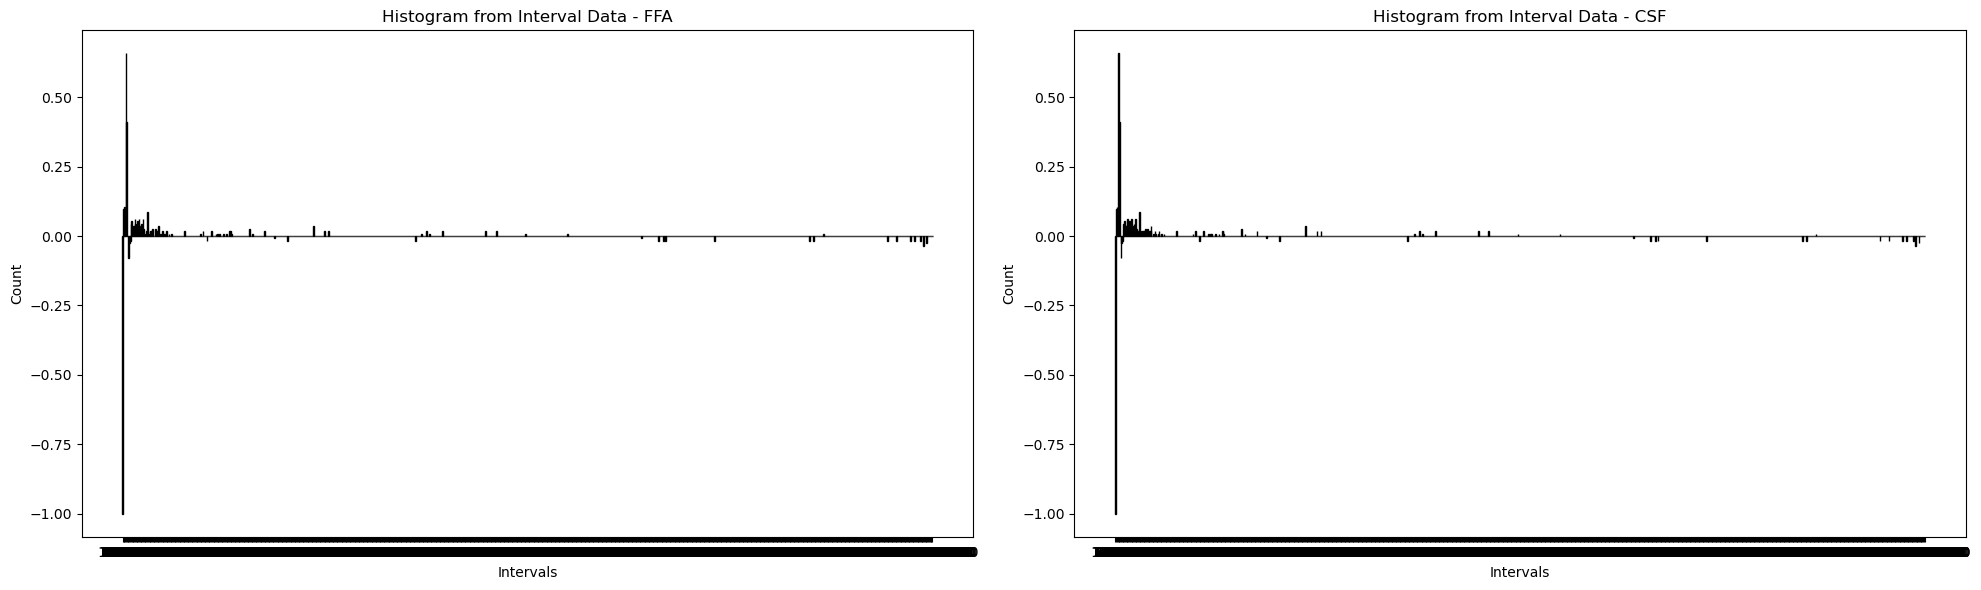

In [49]:
compute("util_0_7")

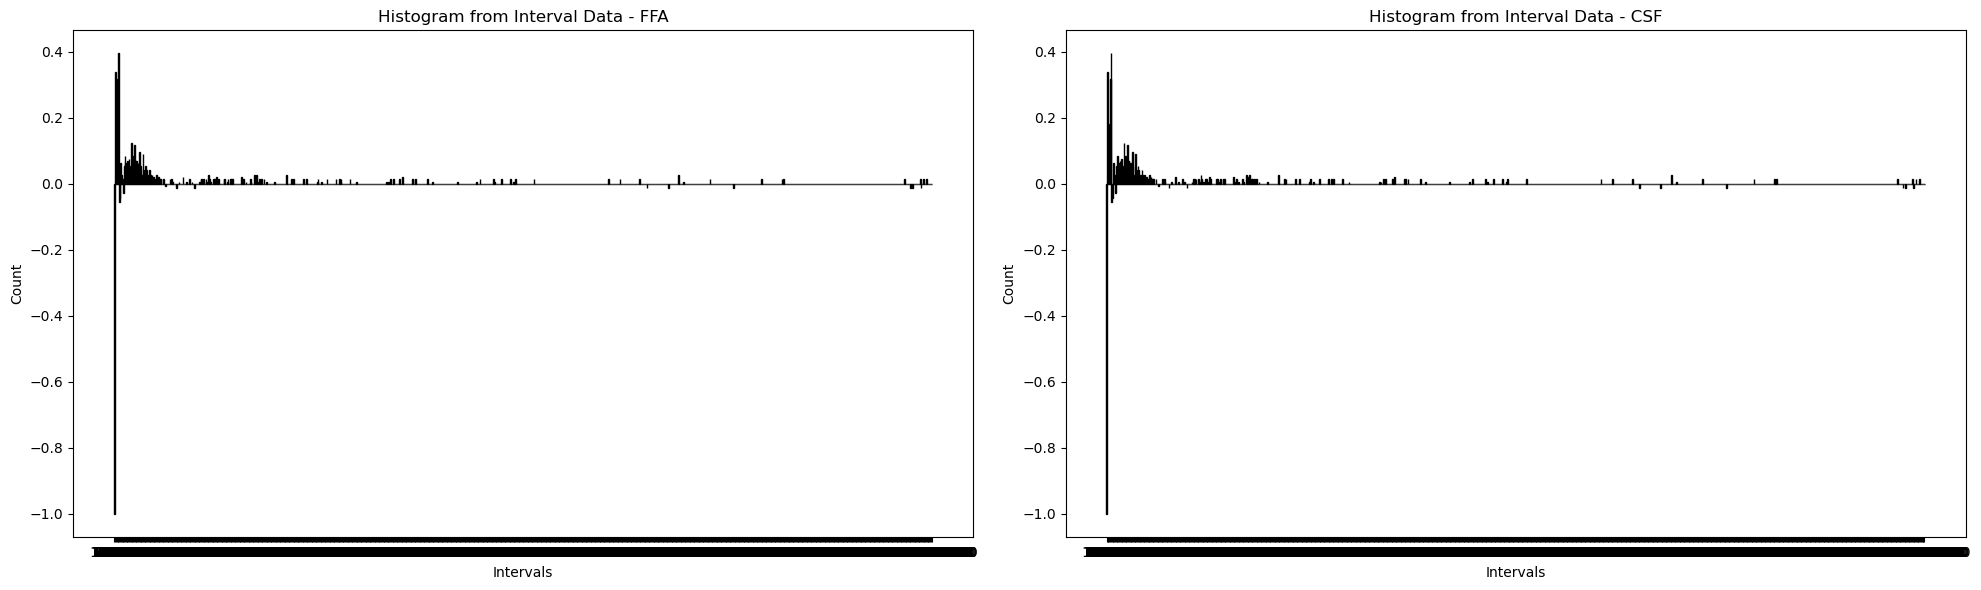

In [50]:
compute("util_0_8")

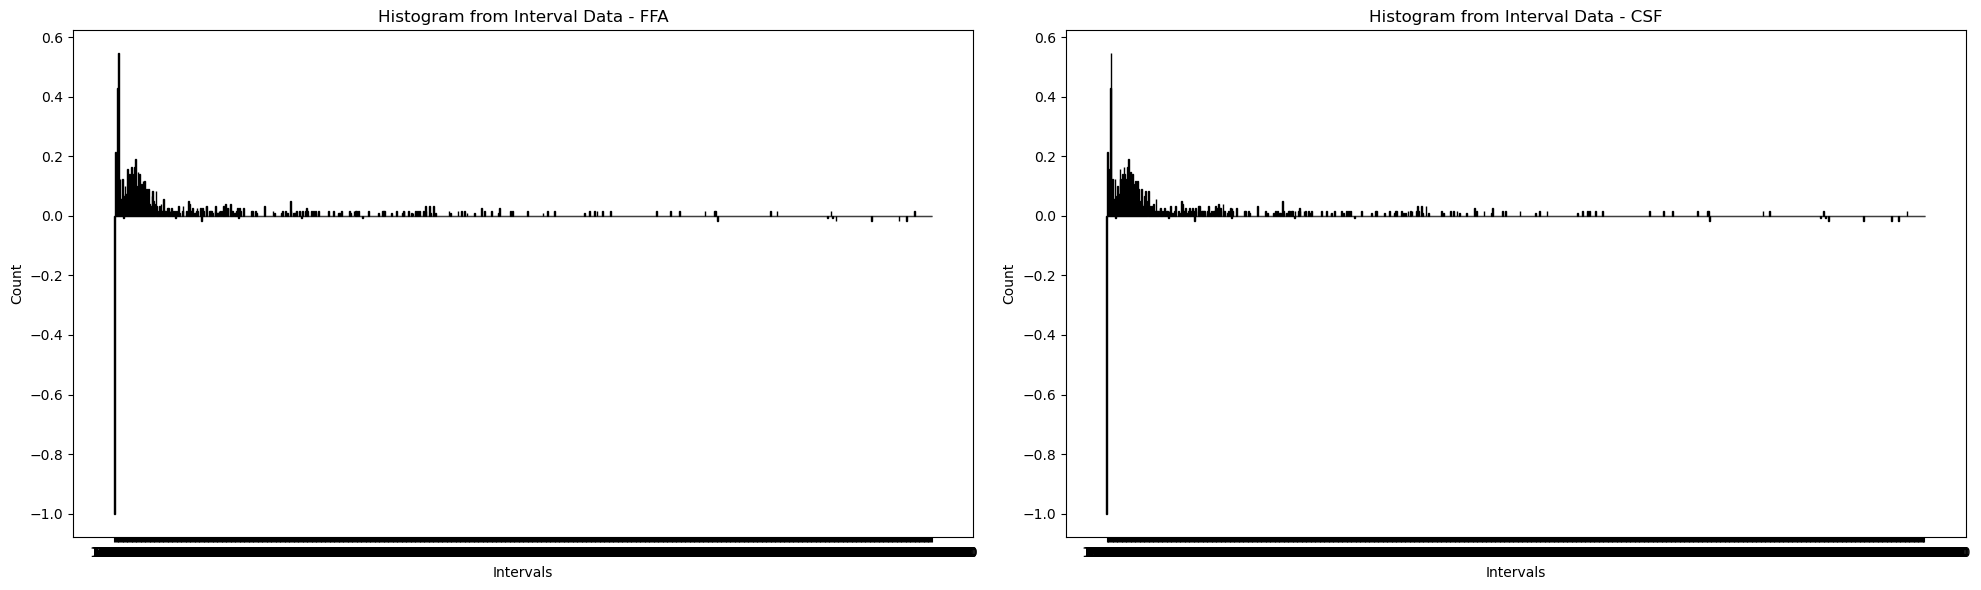

In [51]:
compute("util_0_9")

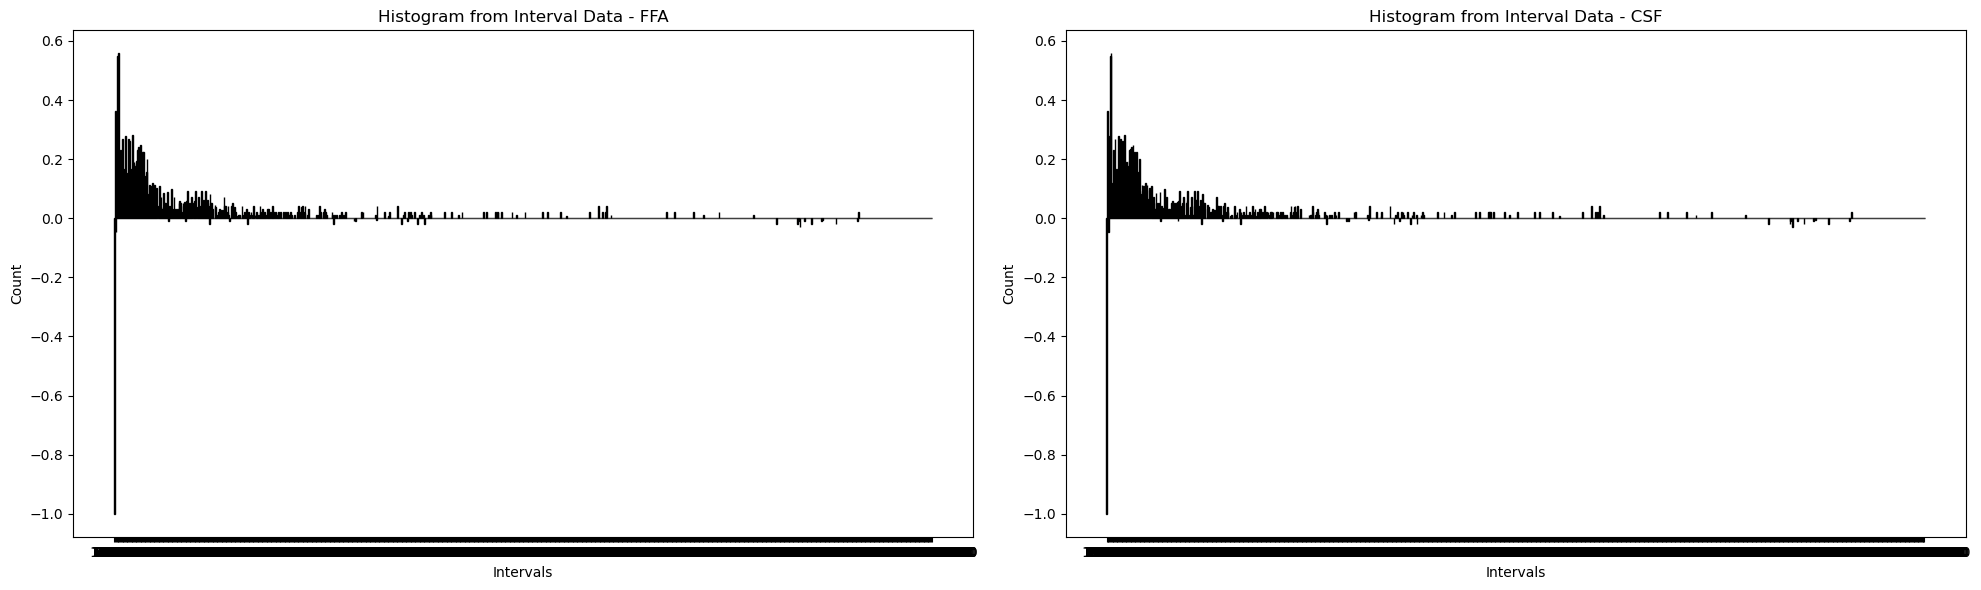

In [52]:
compute("util_1_0")

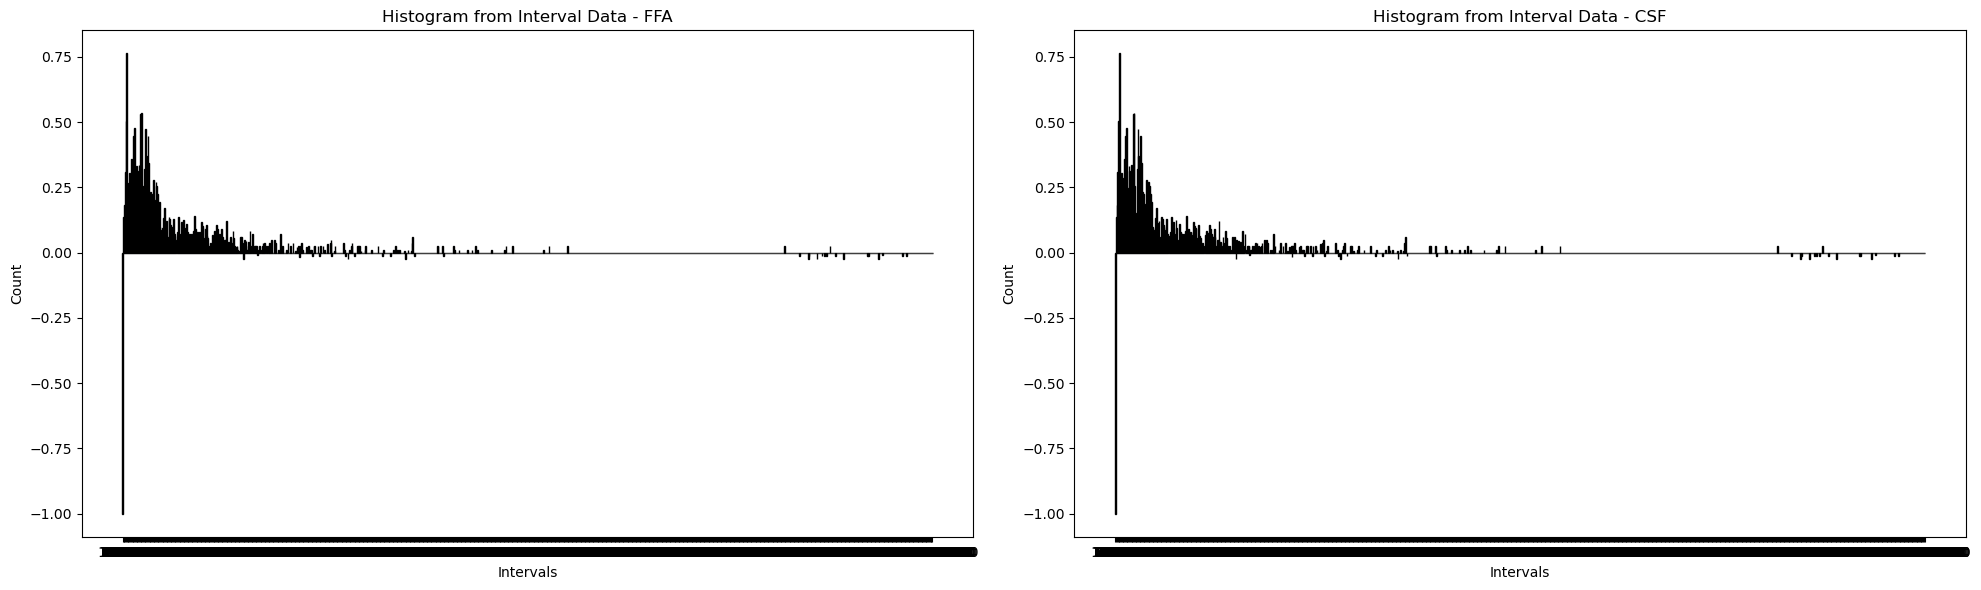

In [53]:
compute("util_1_1")

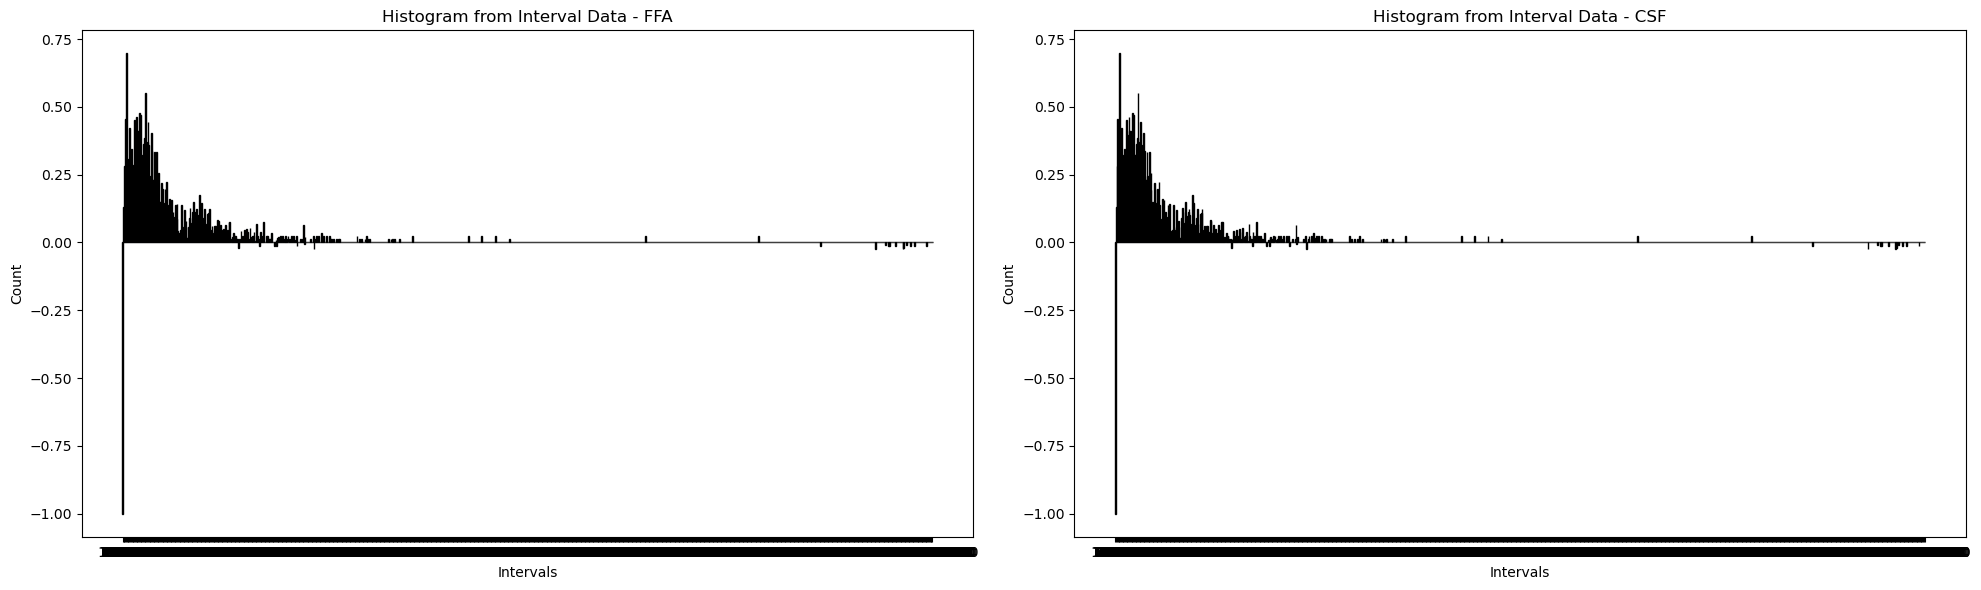

In [54]:
compute("util_1_2")

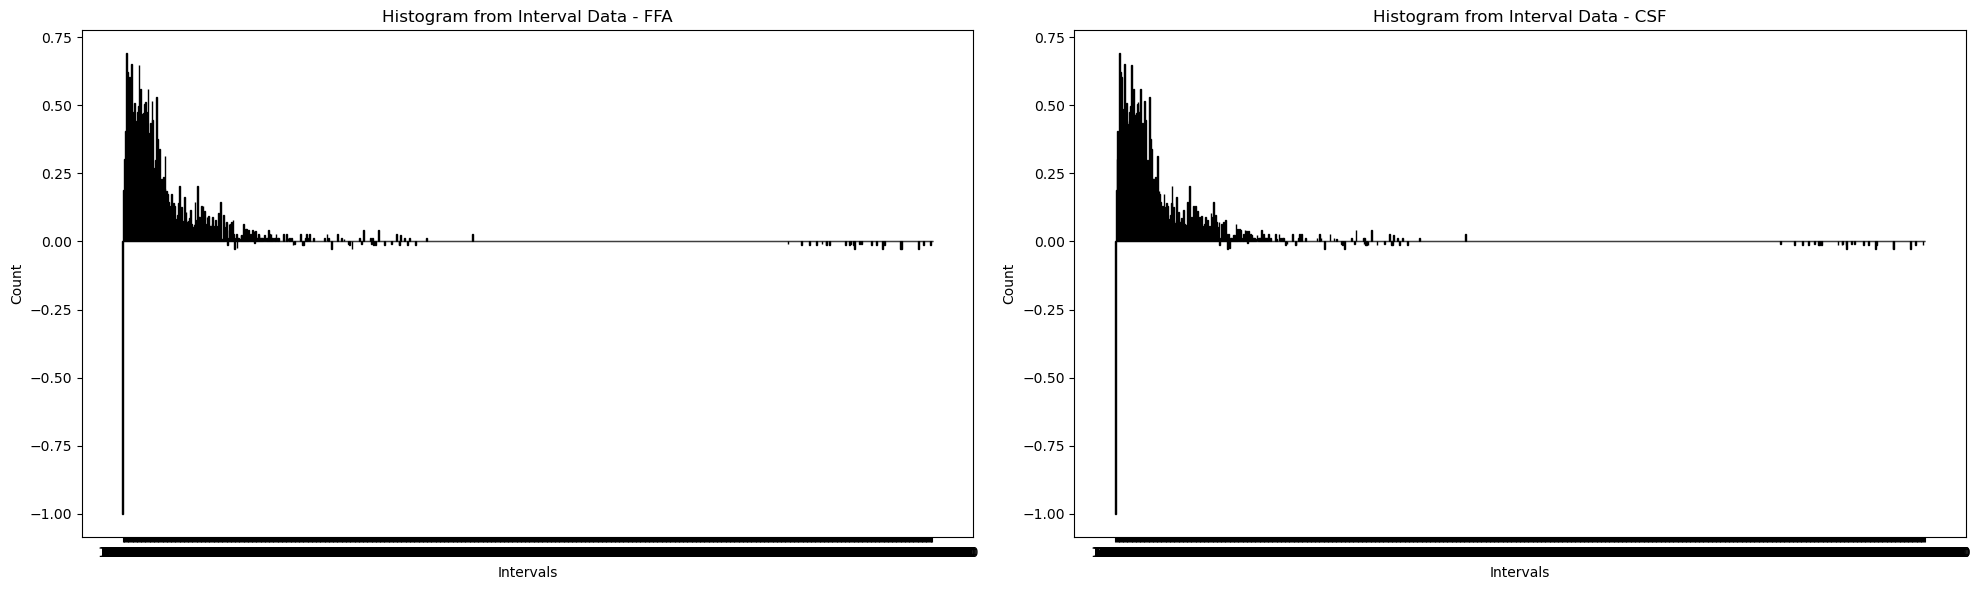

In [55]:
compute("util_1_3")

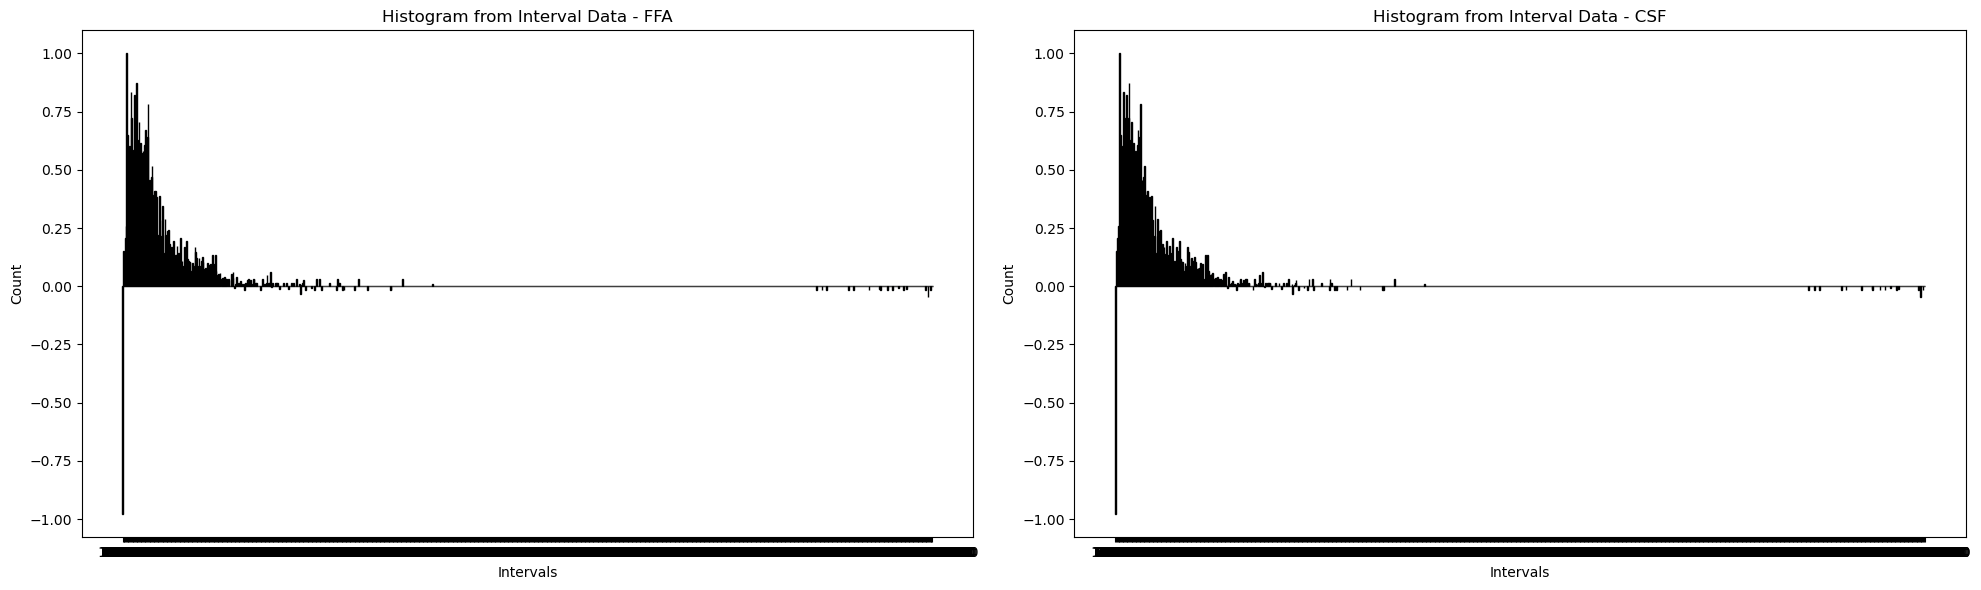

In [56]:
compute("util_1_4")

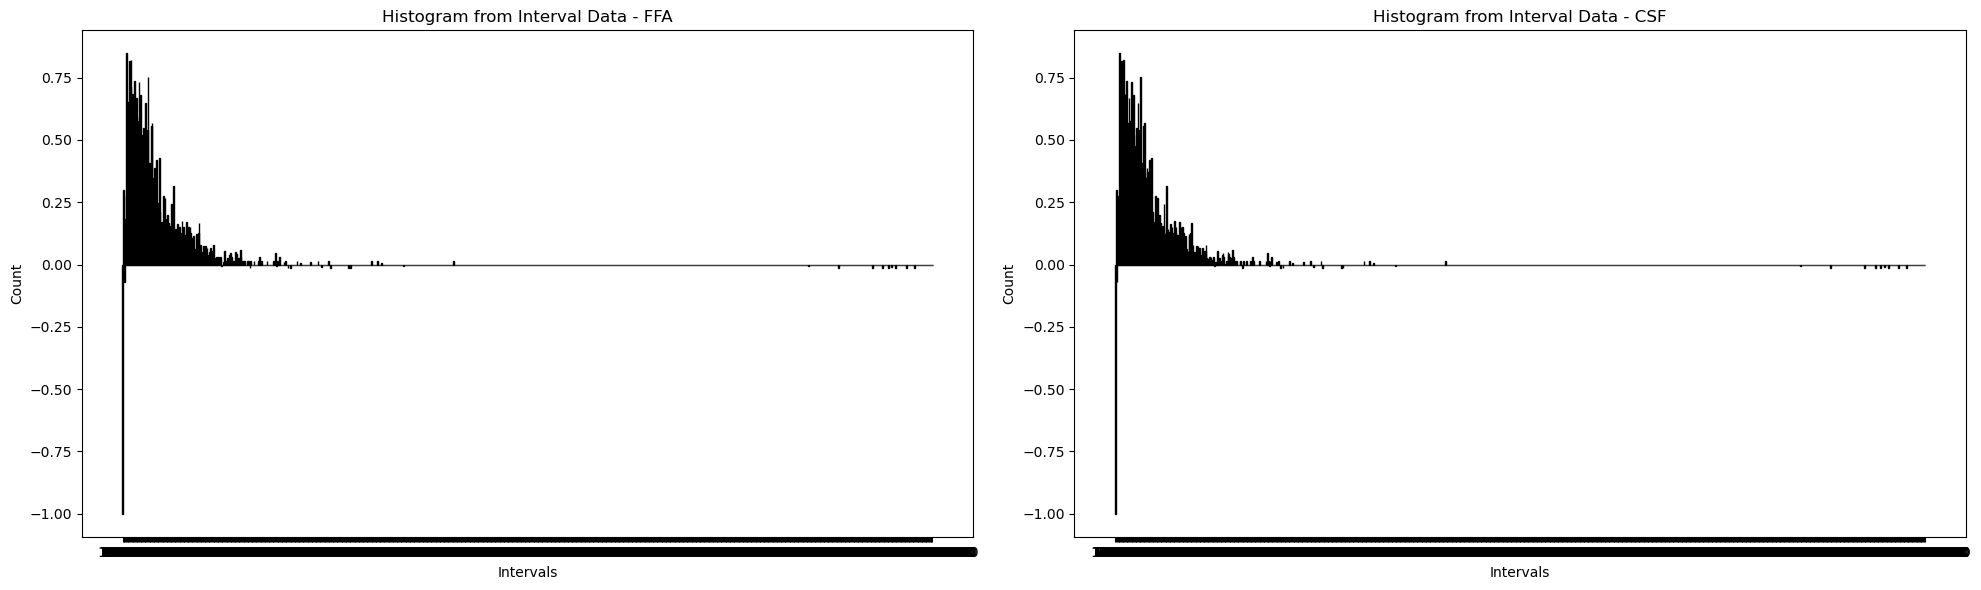

In [57]:
compute("util_1_5")

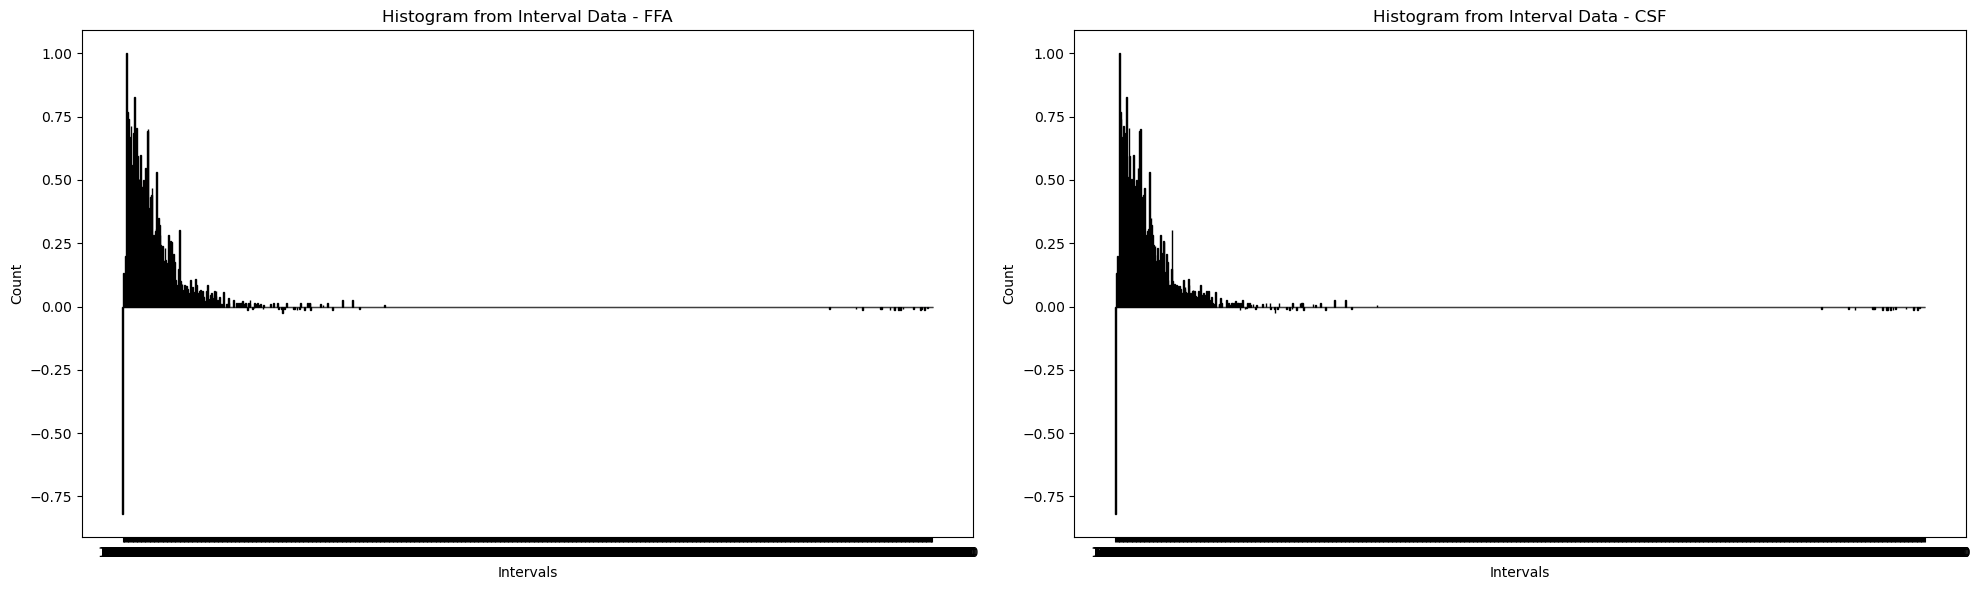

In [58]:
compute("util_1_6")

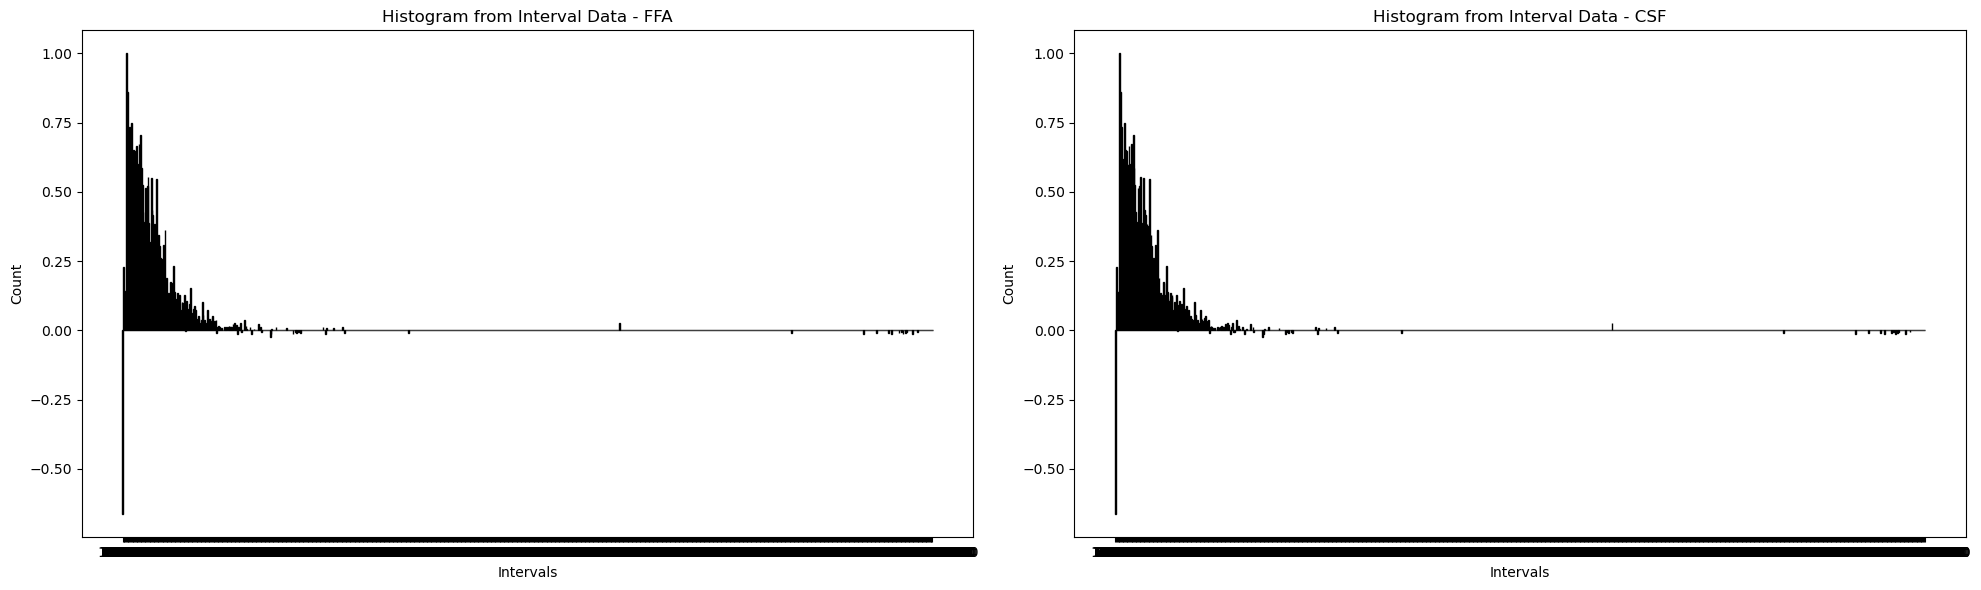

In [59]:
compute("util_1_7")

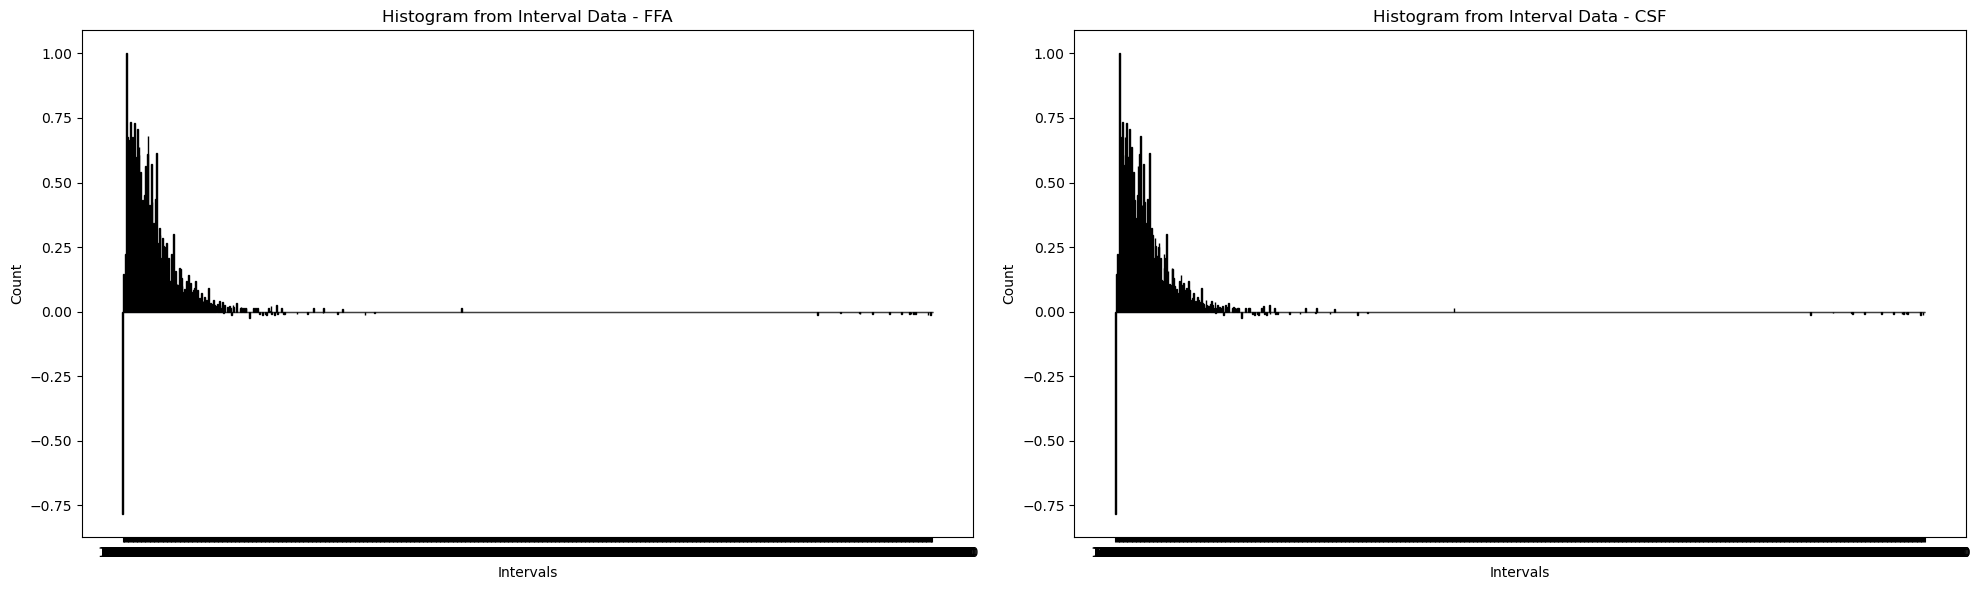

In [60]:
compute("util_1_8")

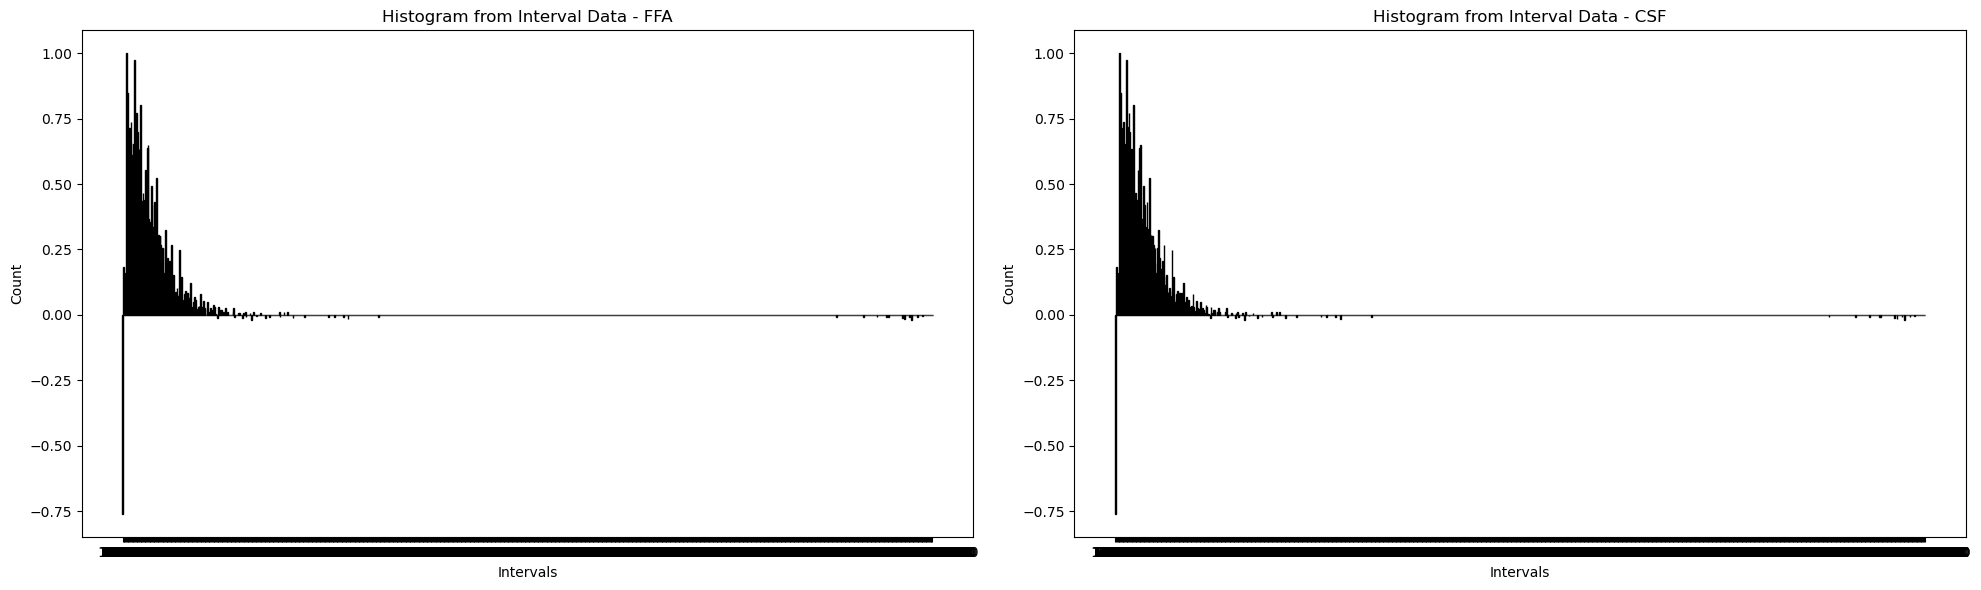

In [61]:
compute("util_1_9")

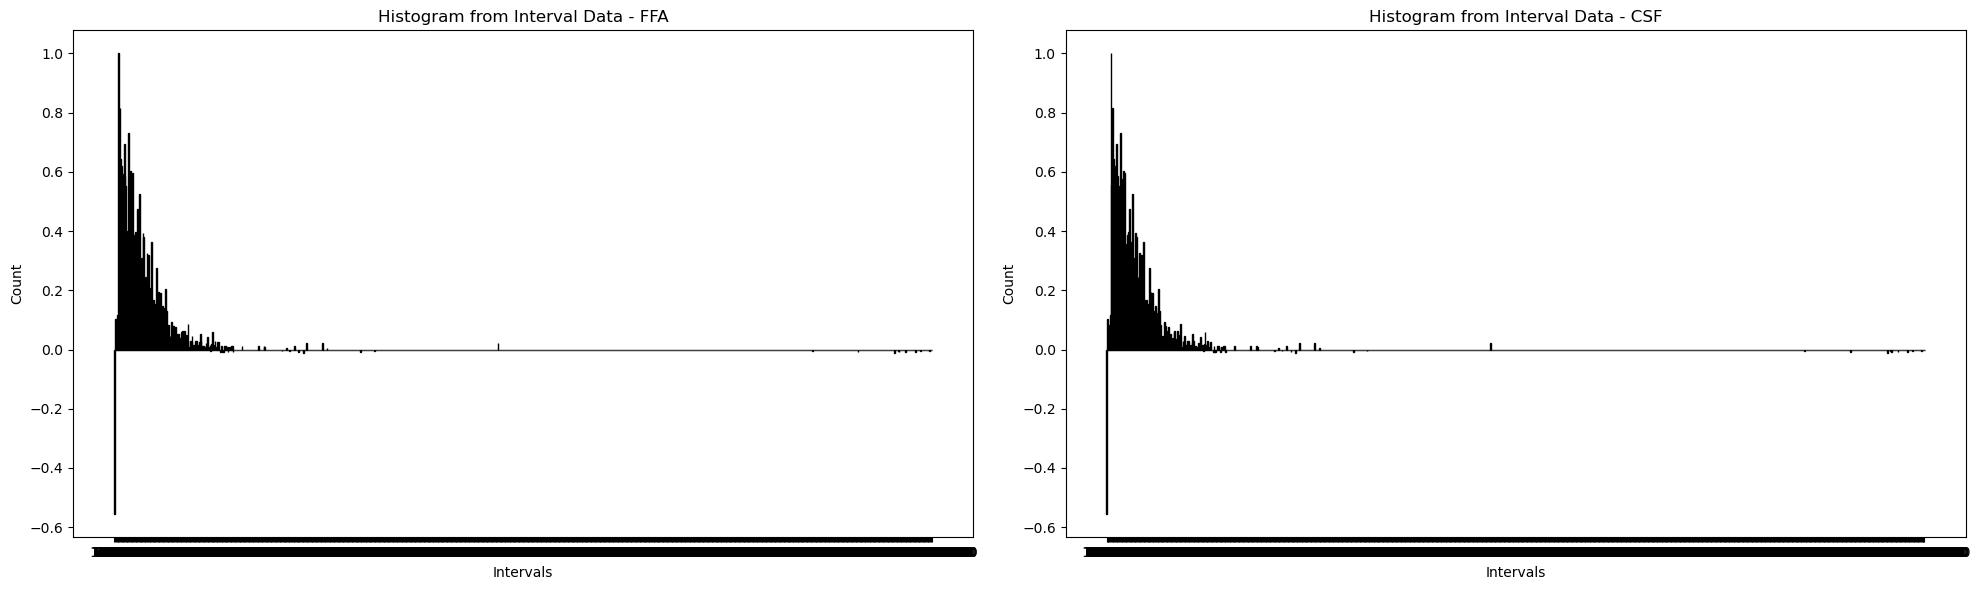

In [62]:
compute("util_2_0")

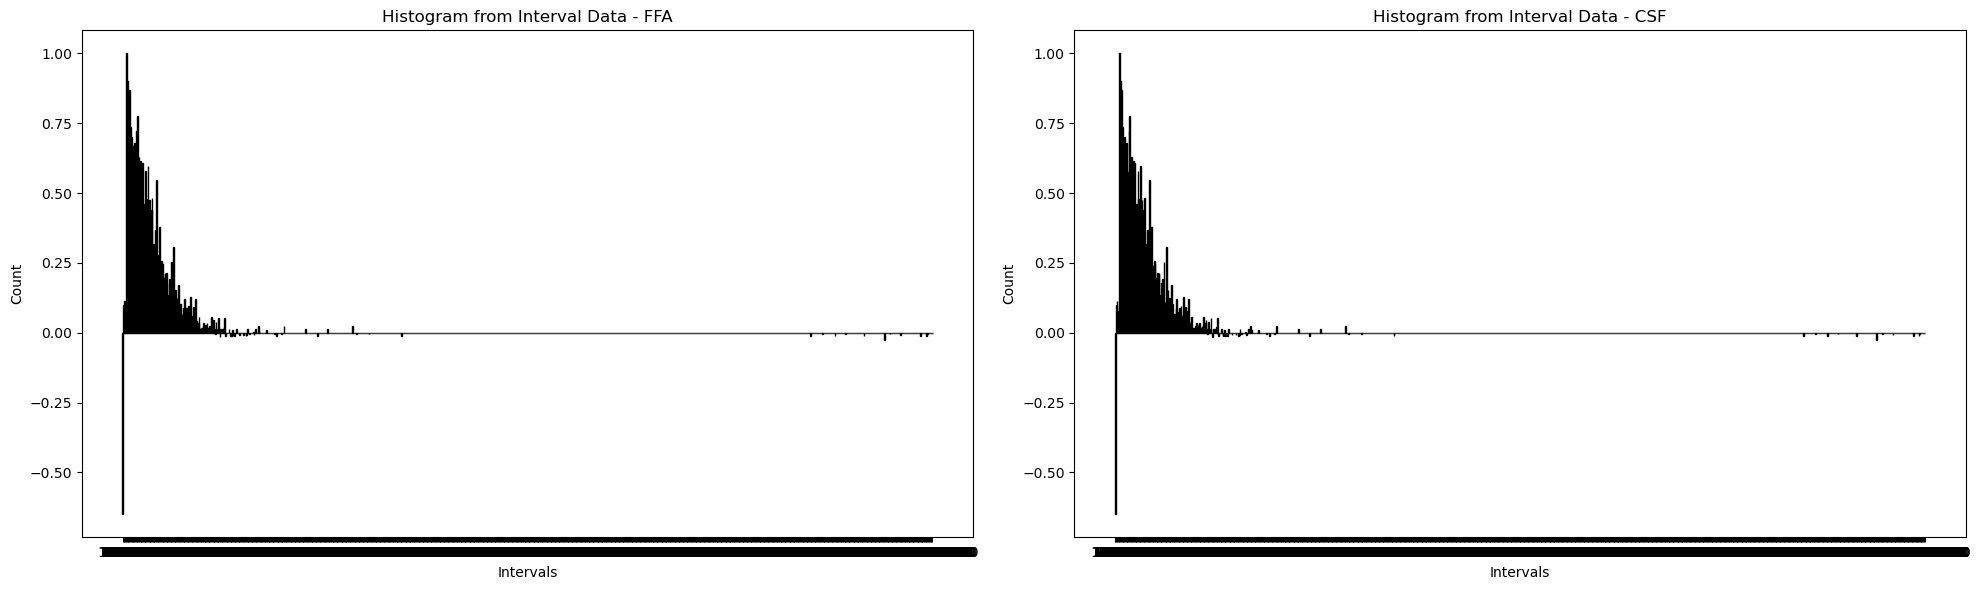

In [63]:
compute("util_2_1")

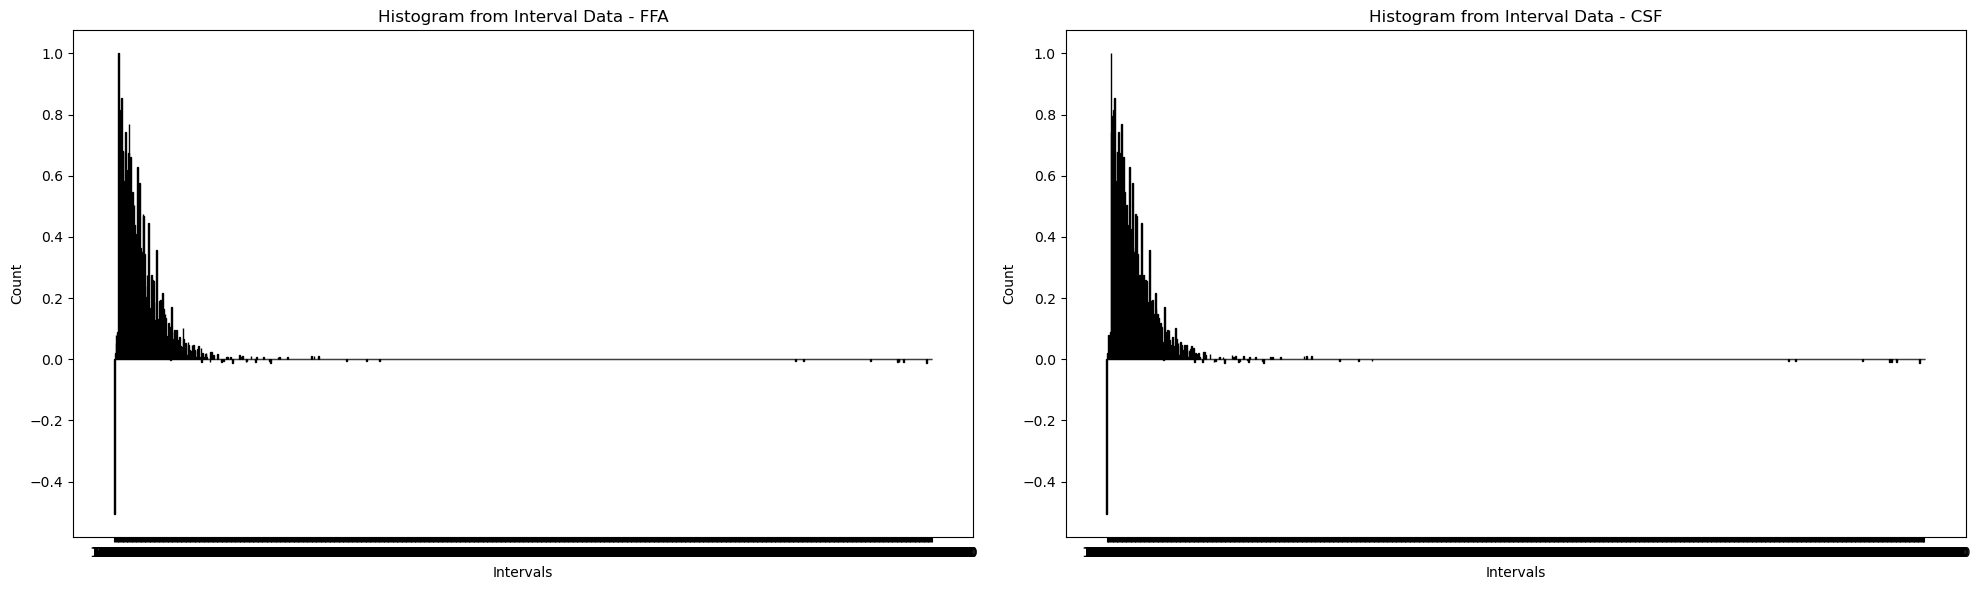

In [64]:
compute("util_2_2")

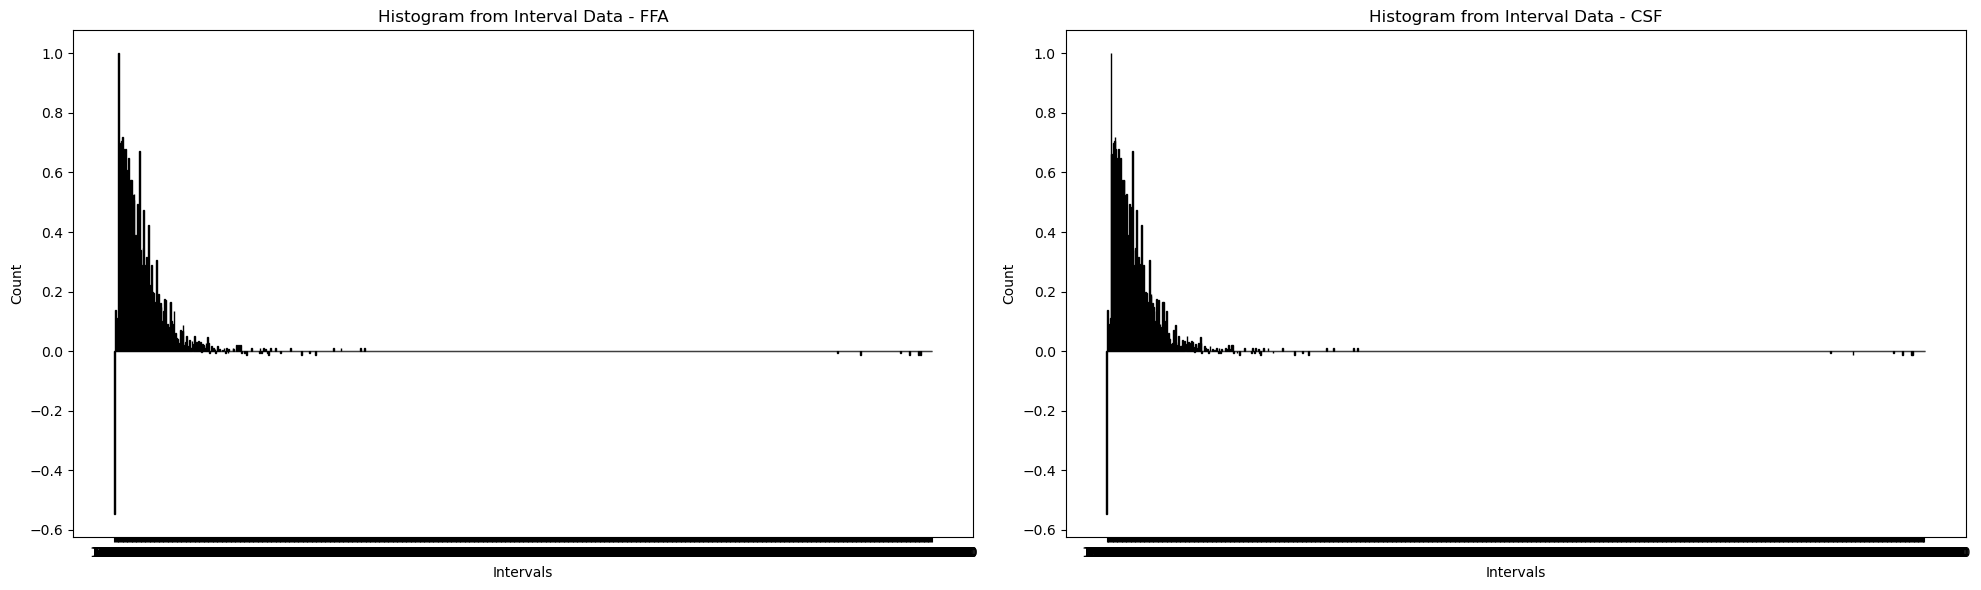

In [65]:
compute("util_2_3")

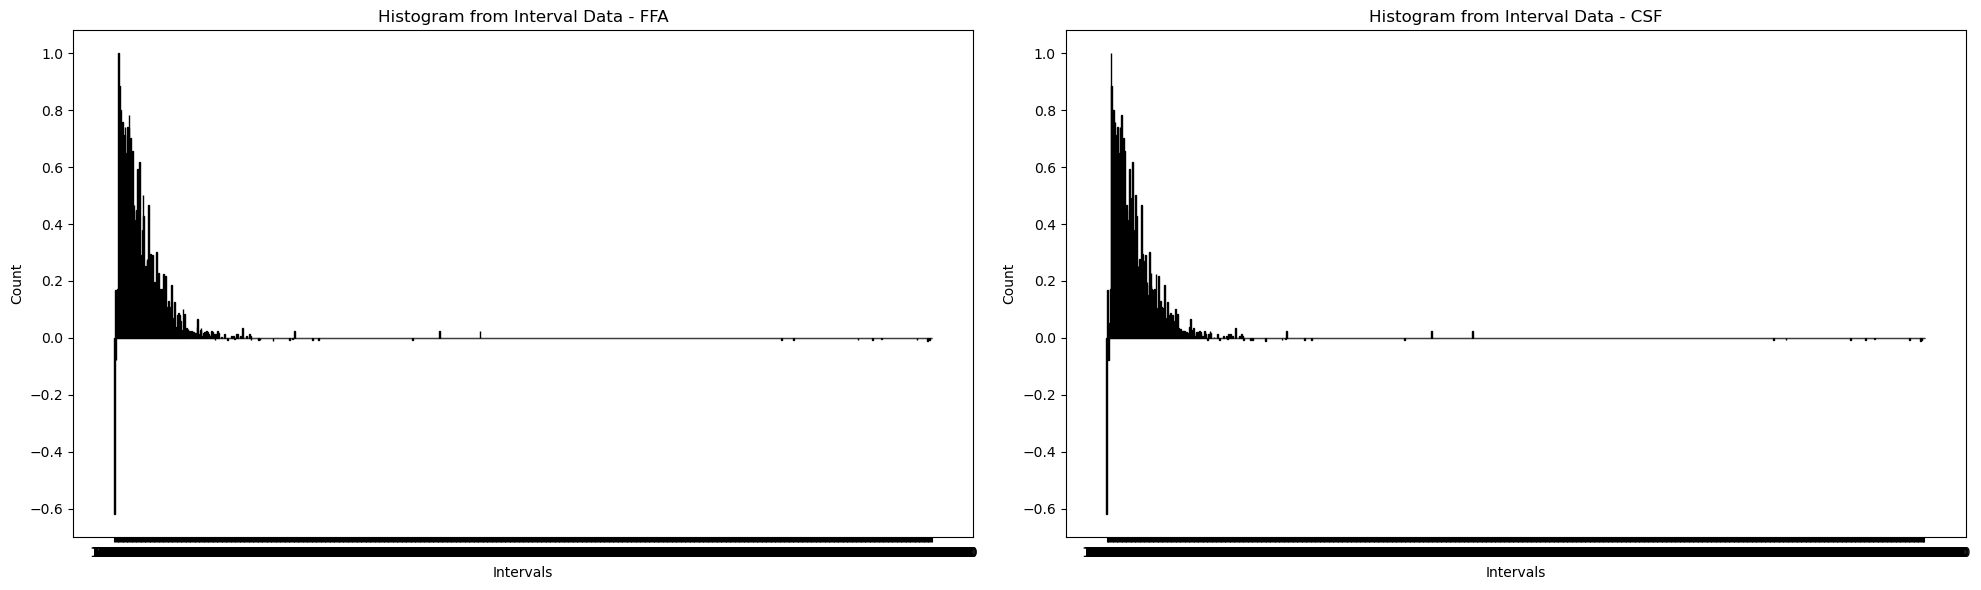

In [66]:
compute("util_2_4")

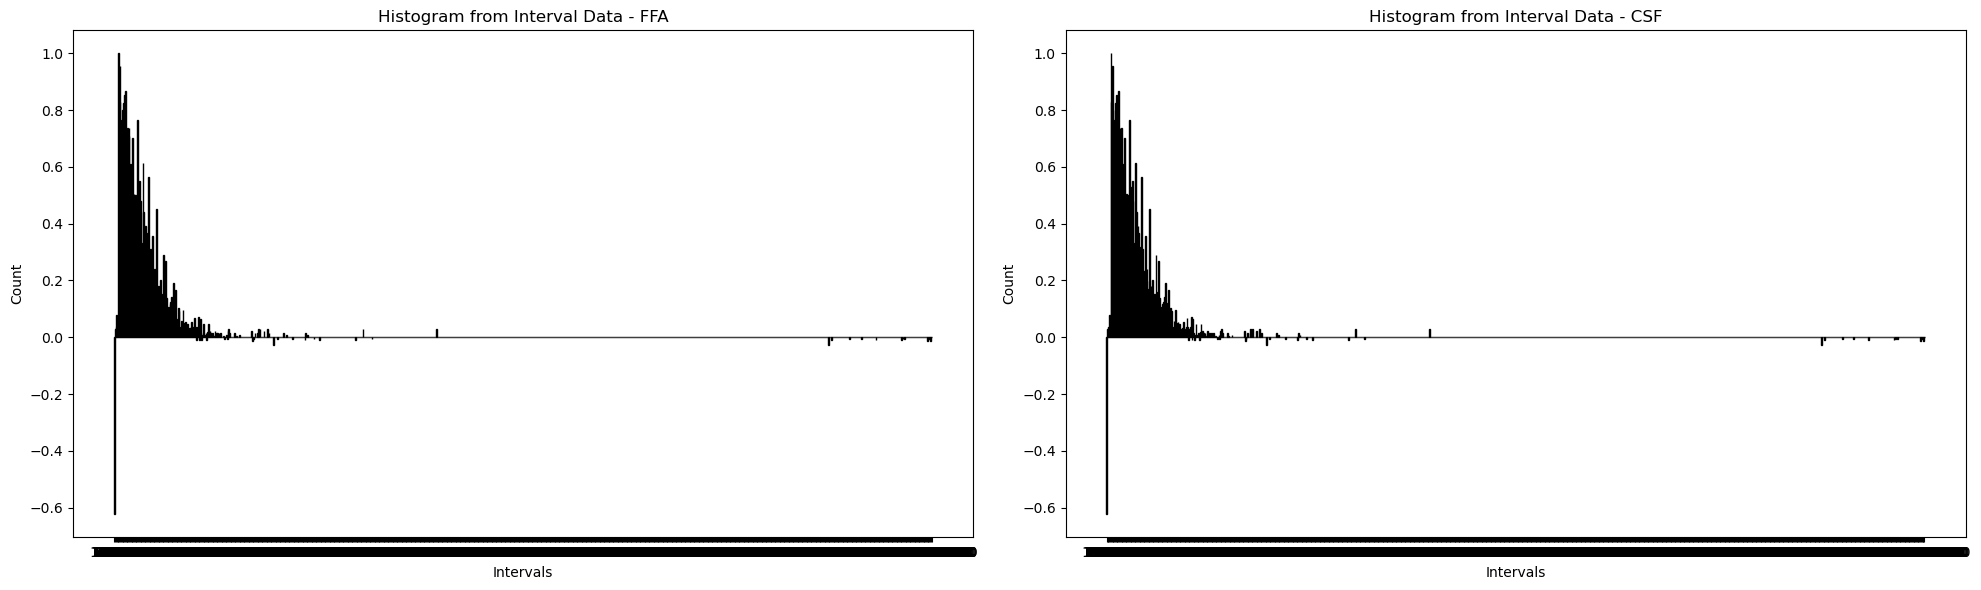

In [67]:
compute("util_2_5")

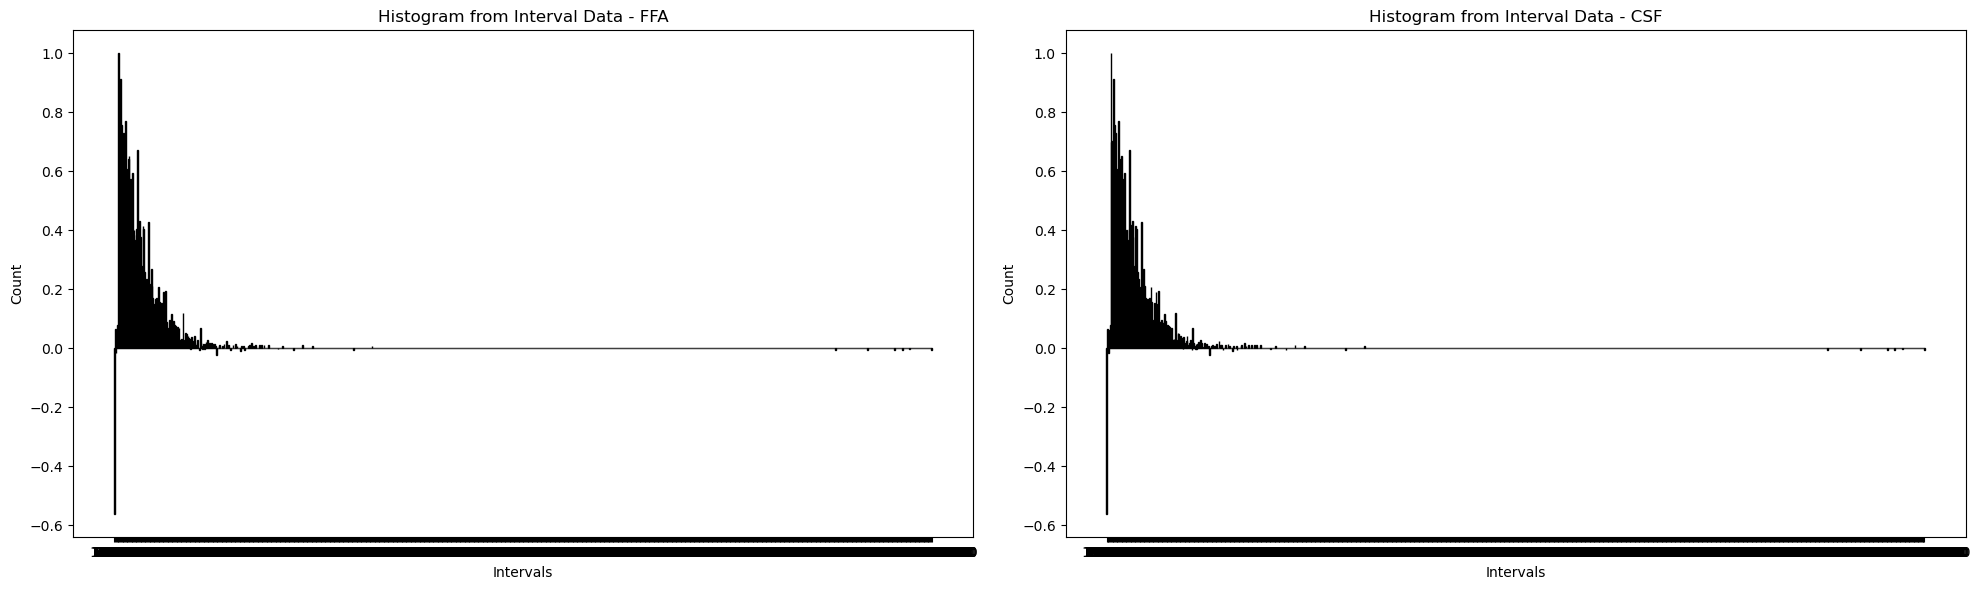

In [68]:
compute("util_2_6")

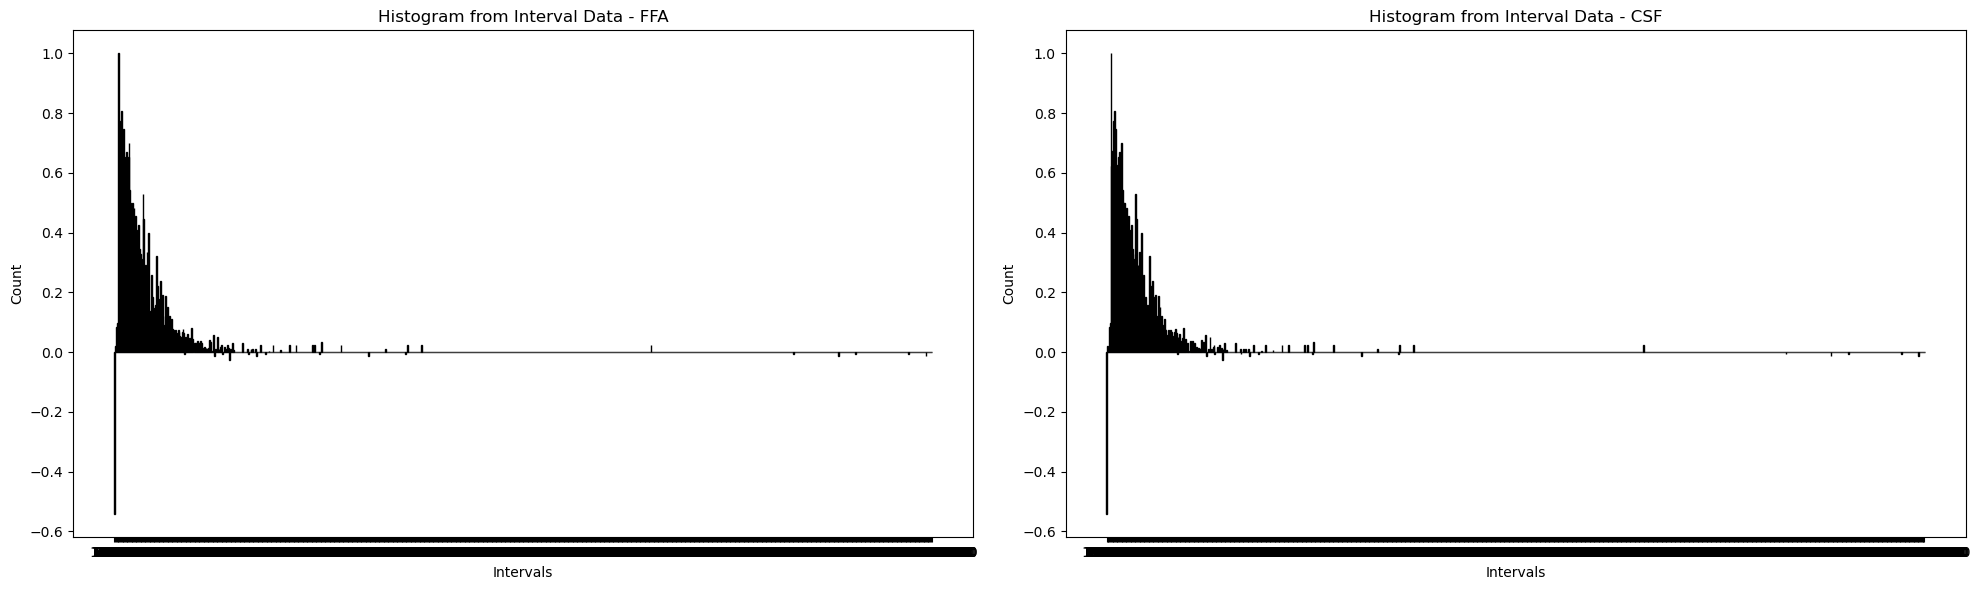

In [69]:
compute("util_2_7")

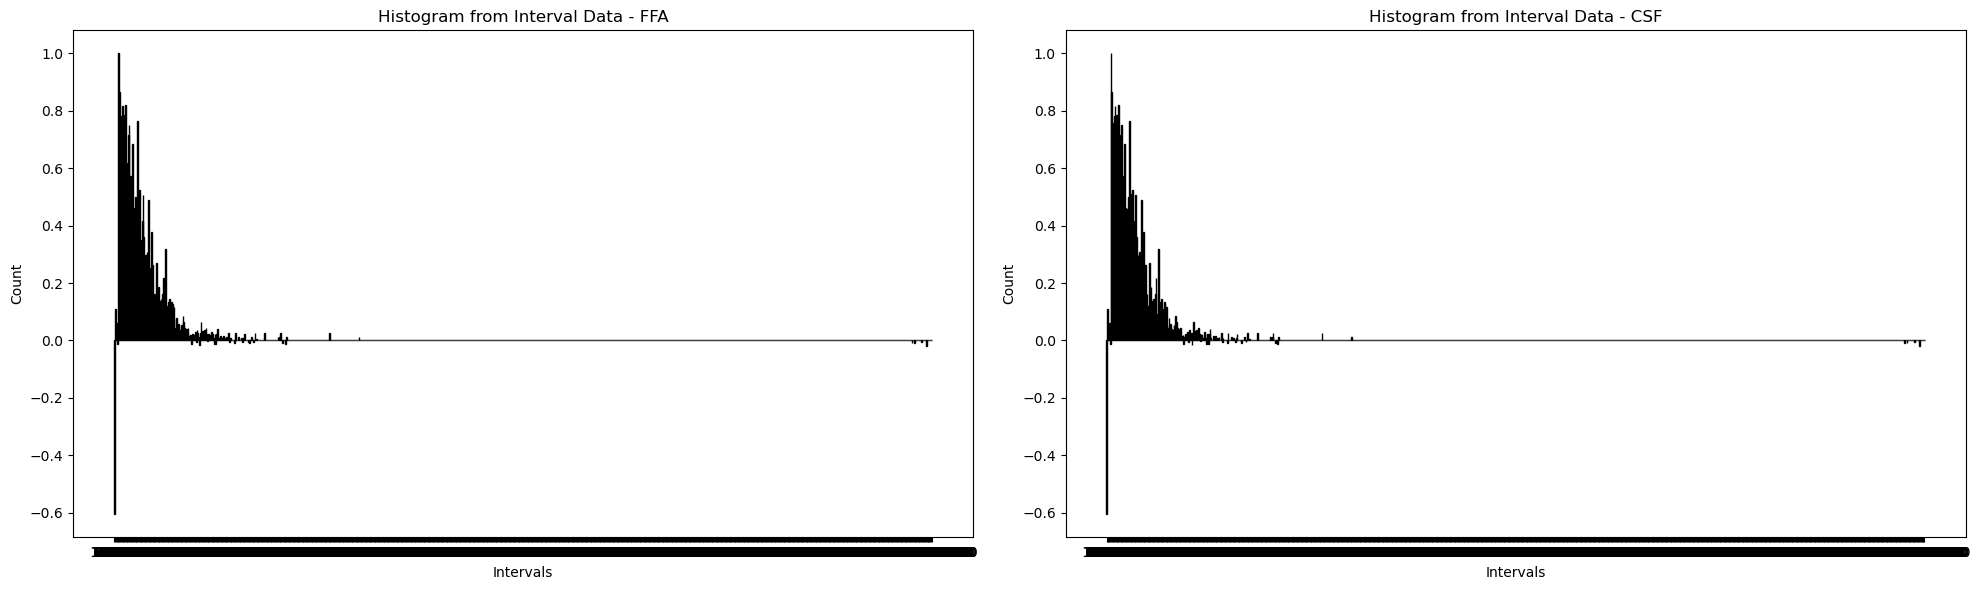

In [70]:
compute("util_2_8")

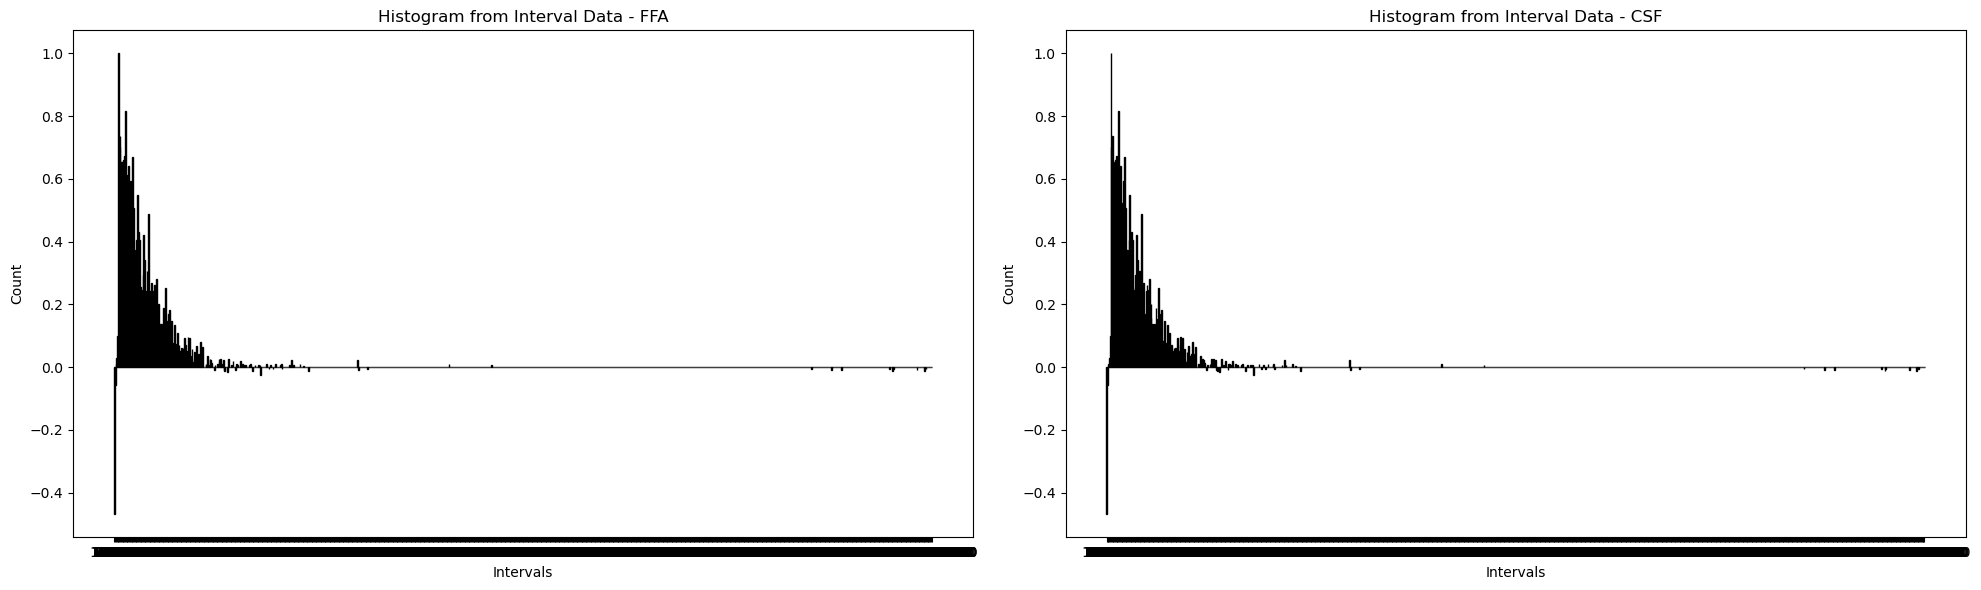

In [71]:
compute("util_2_9")

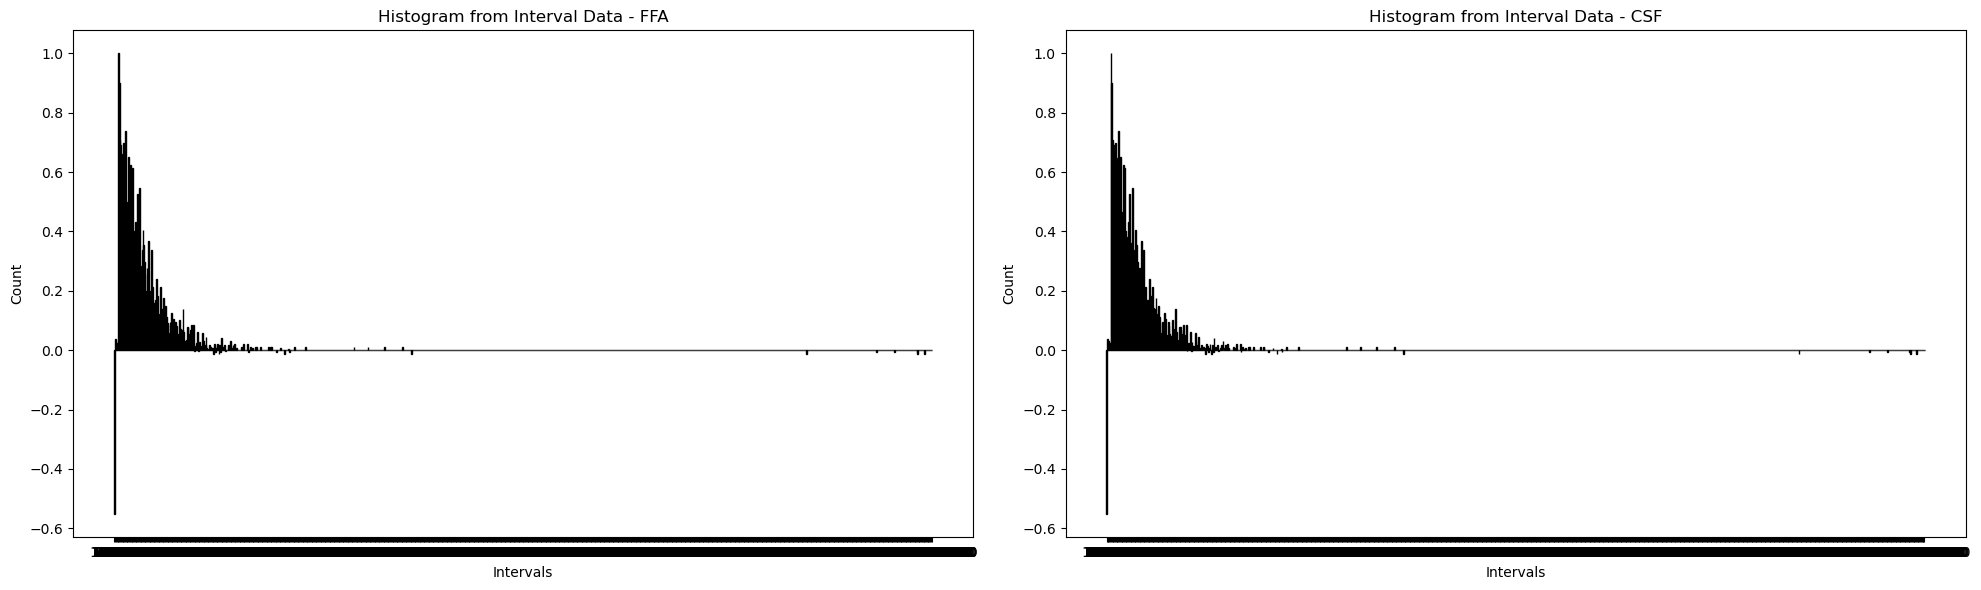

In [72]:
compute("util_3_0")

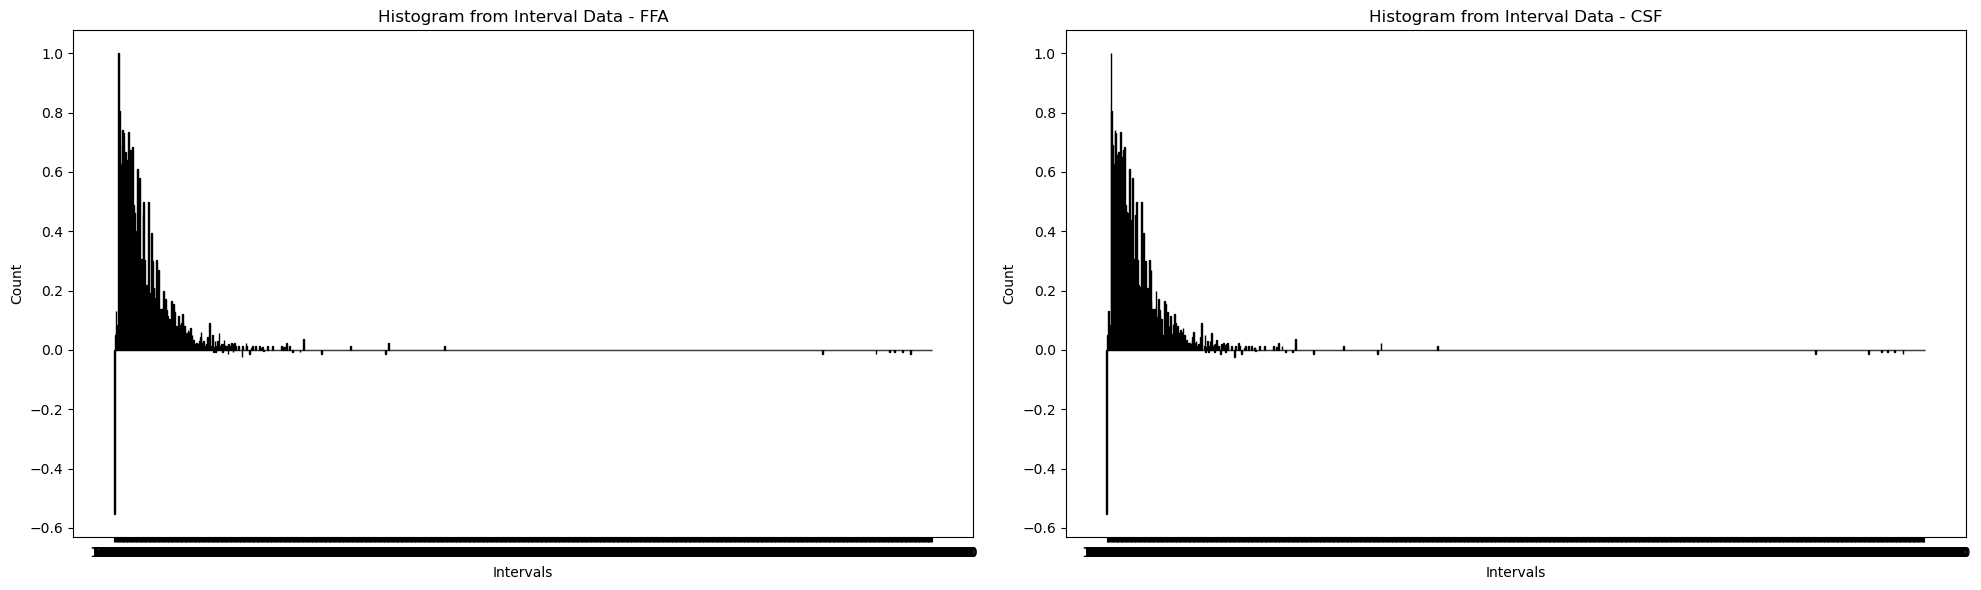

In [73]:
compute("util_3_1")

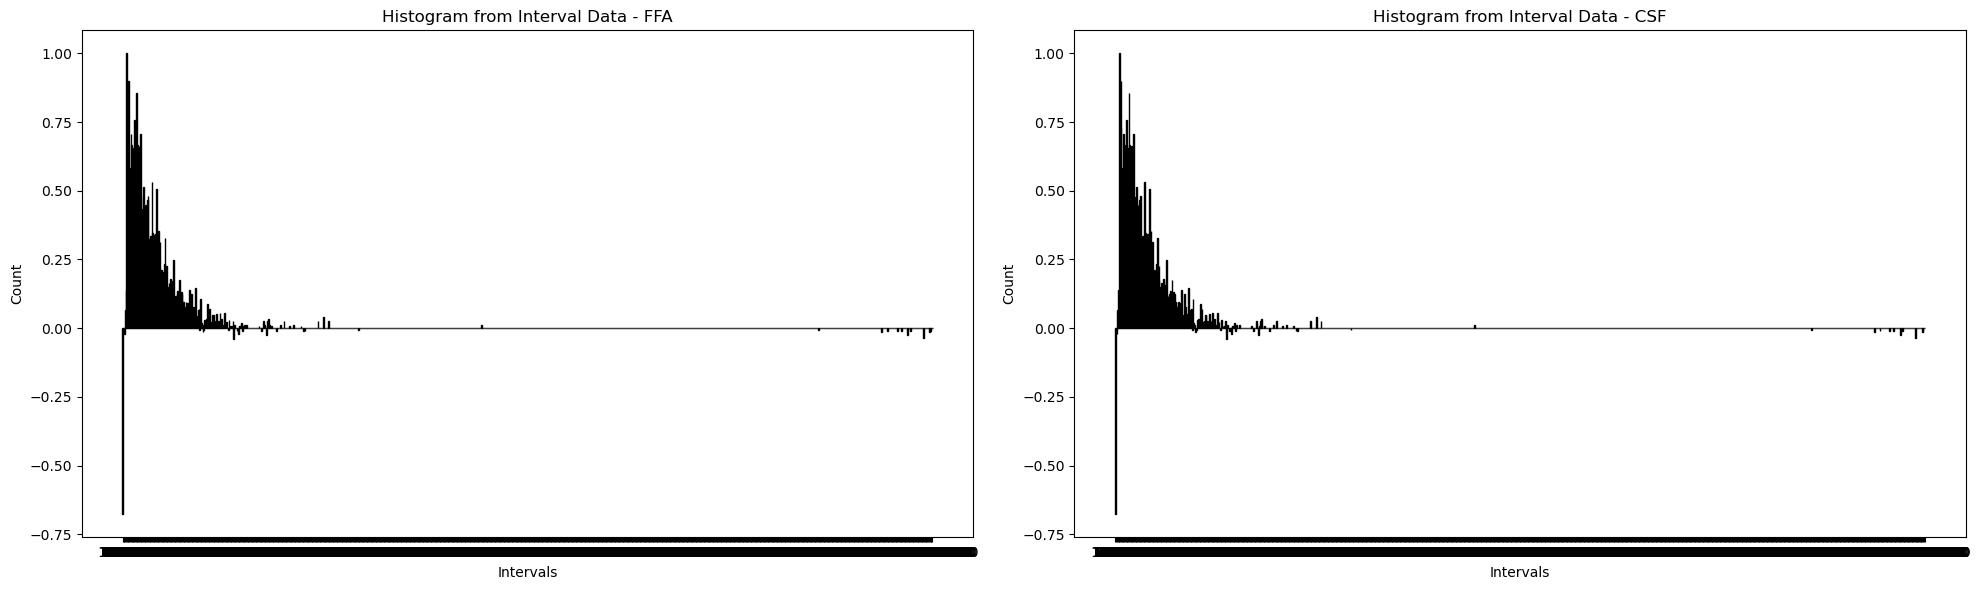

In [74]:
compute("util_3_2")

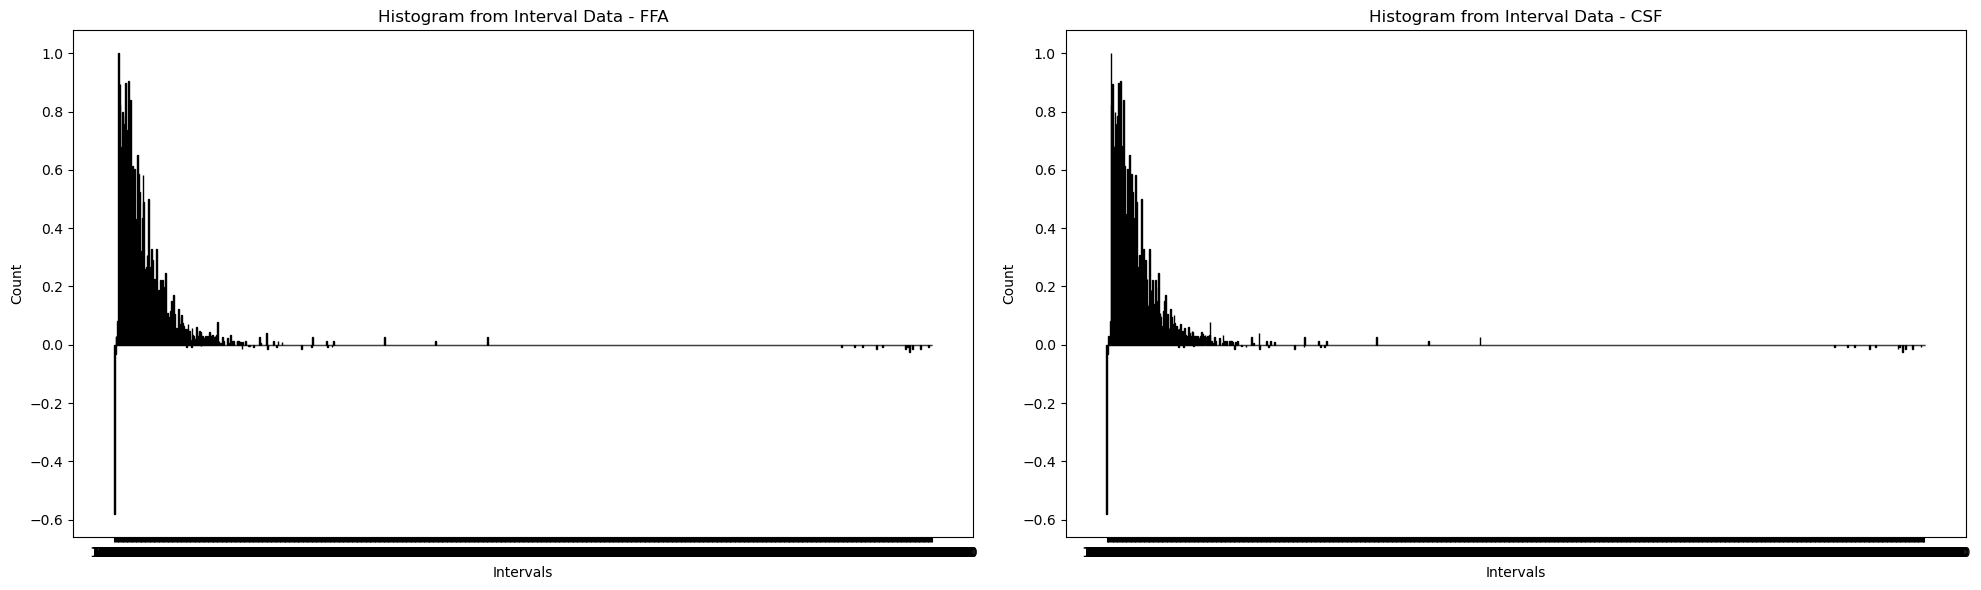

In [75]:
compute("util_3_3")

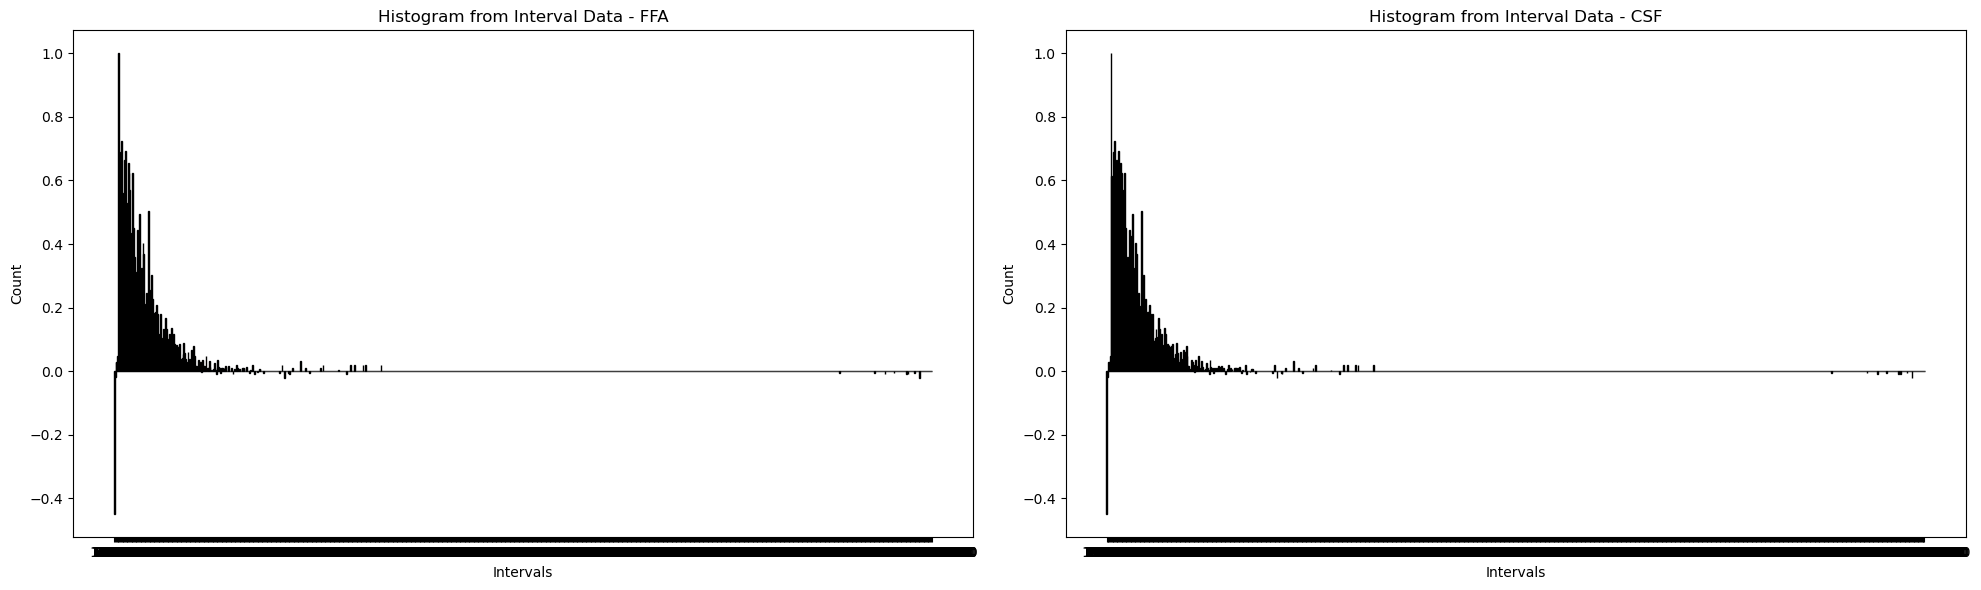

In [76]:
compute("util_3_4")

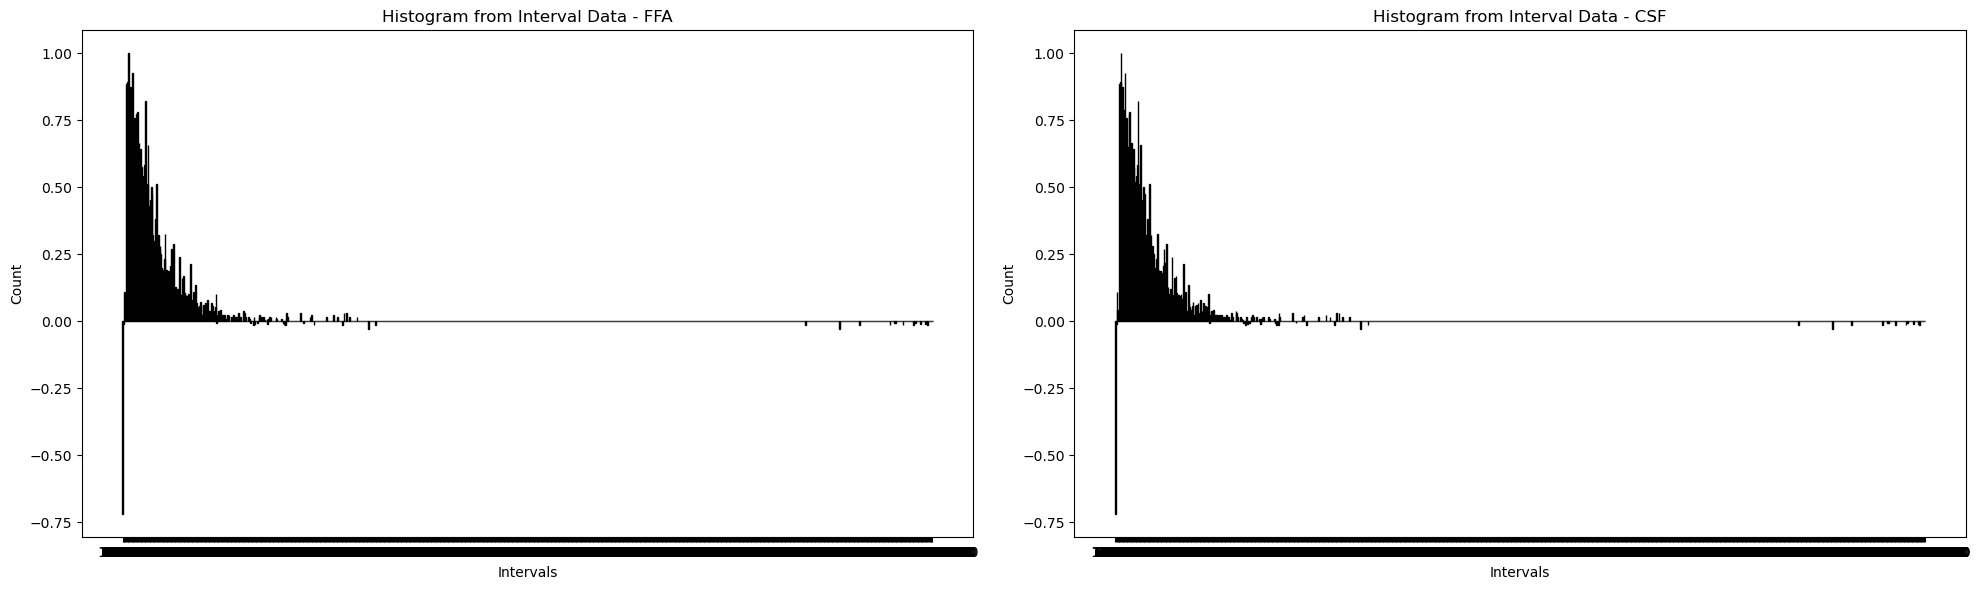

In [77]:
compute("util_3_5")

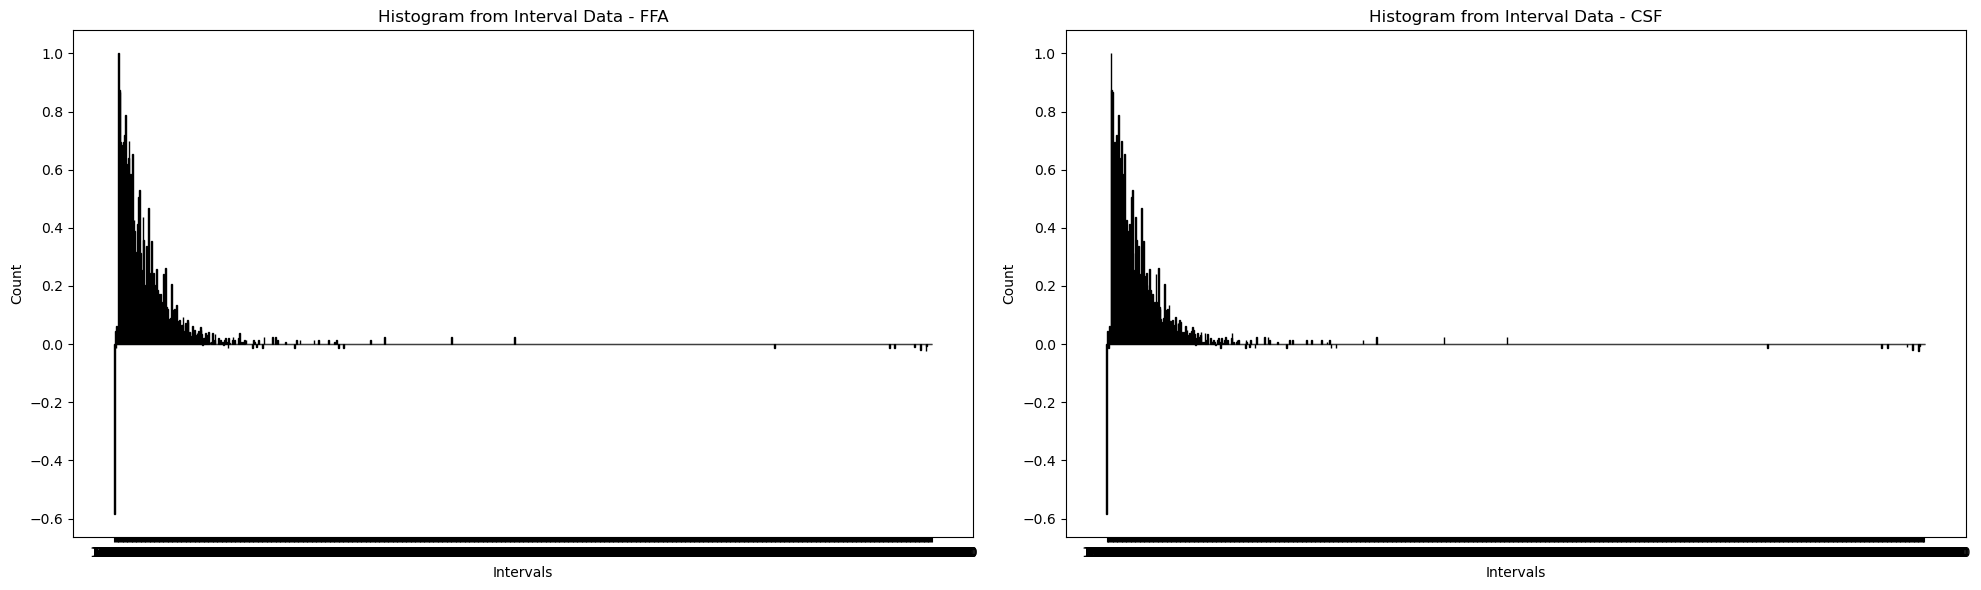

In [78]:
compute("util_3_6")

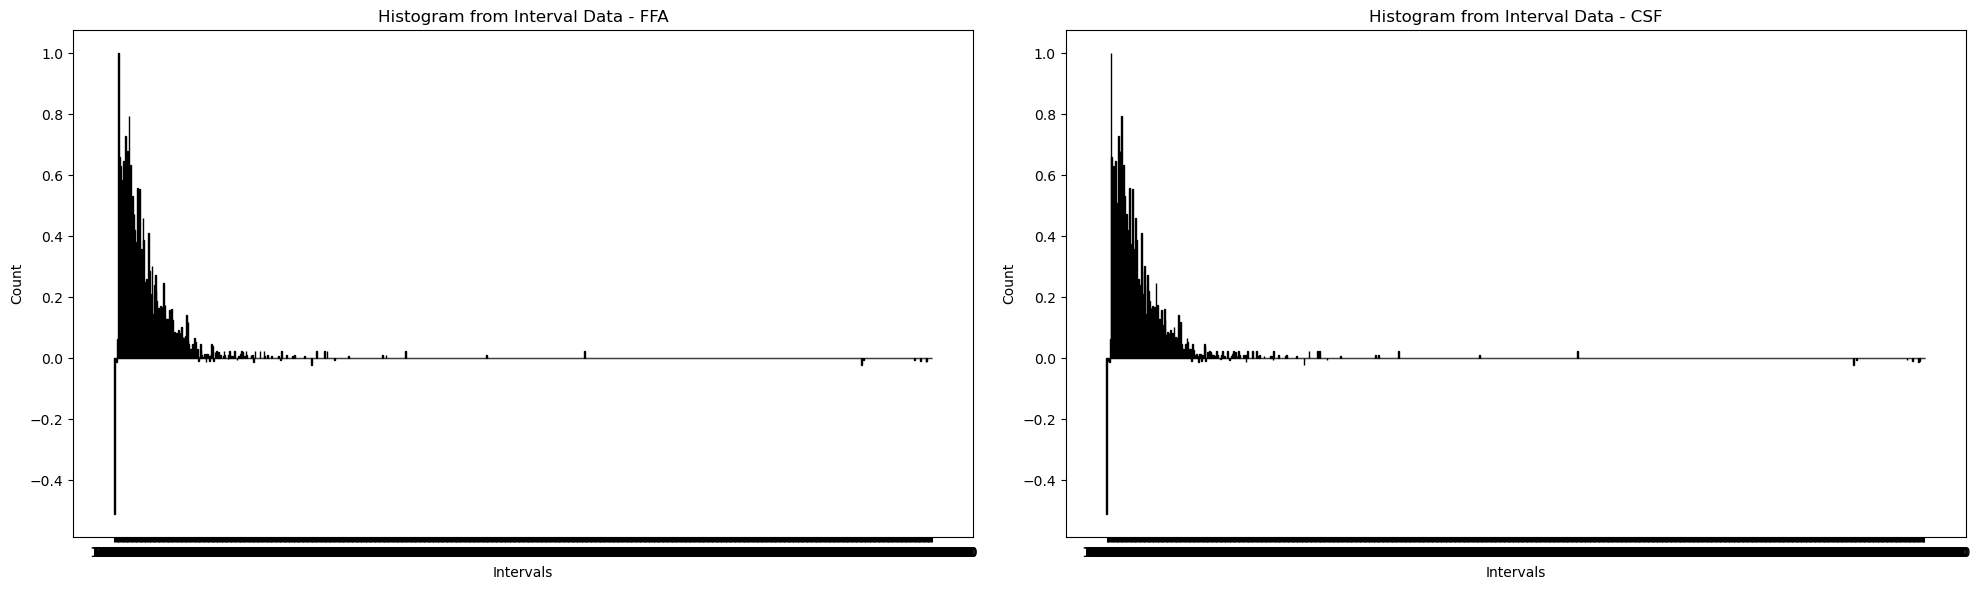

In [79]:
compute("util_3_7")

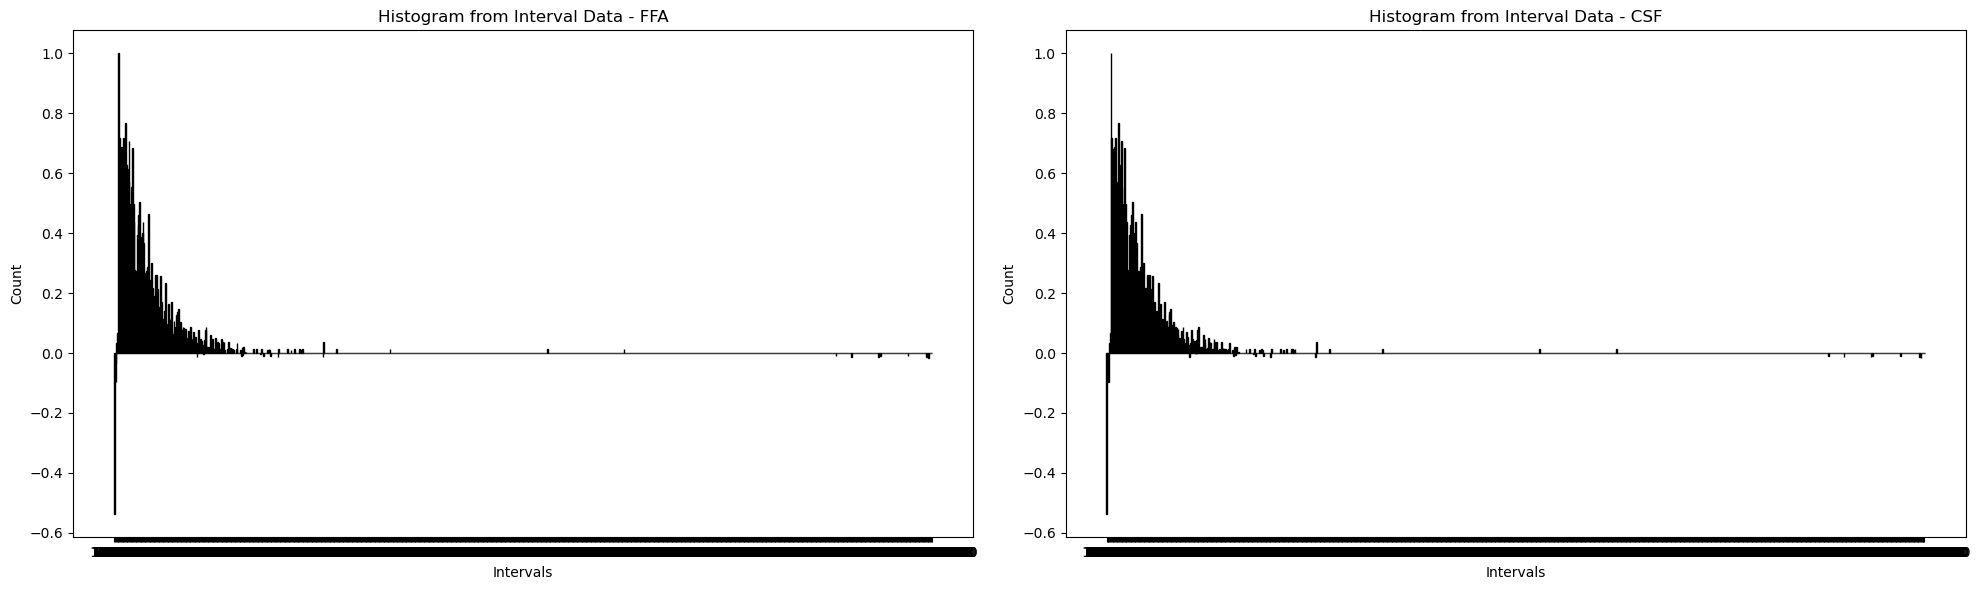

In [80]:
compute("util_3_8")

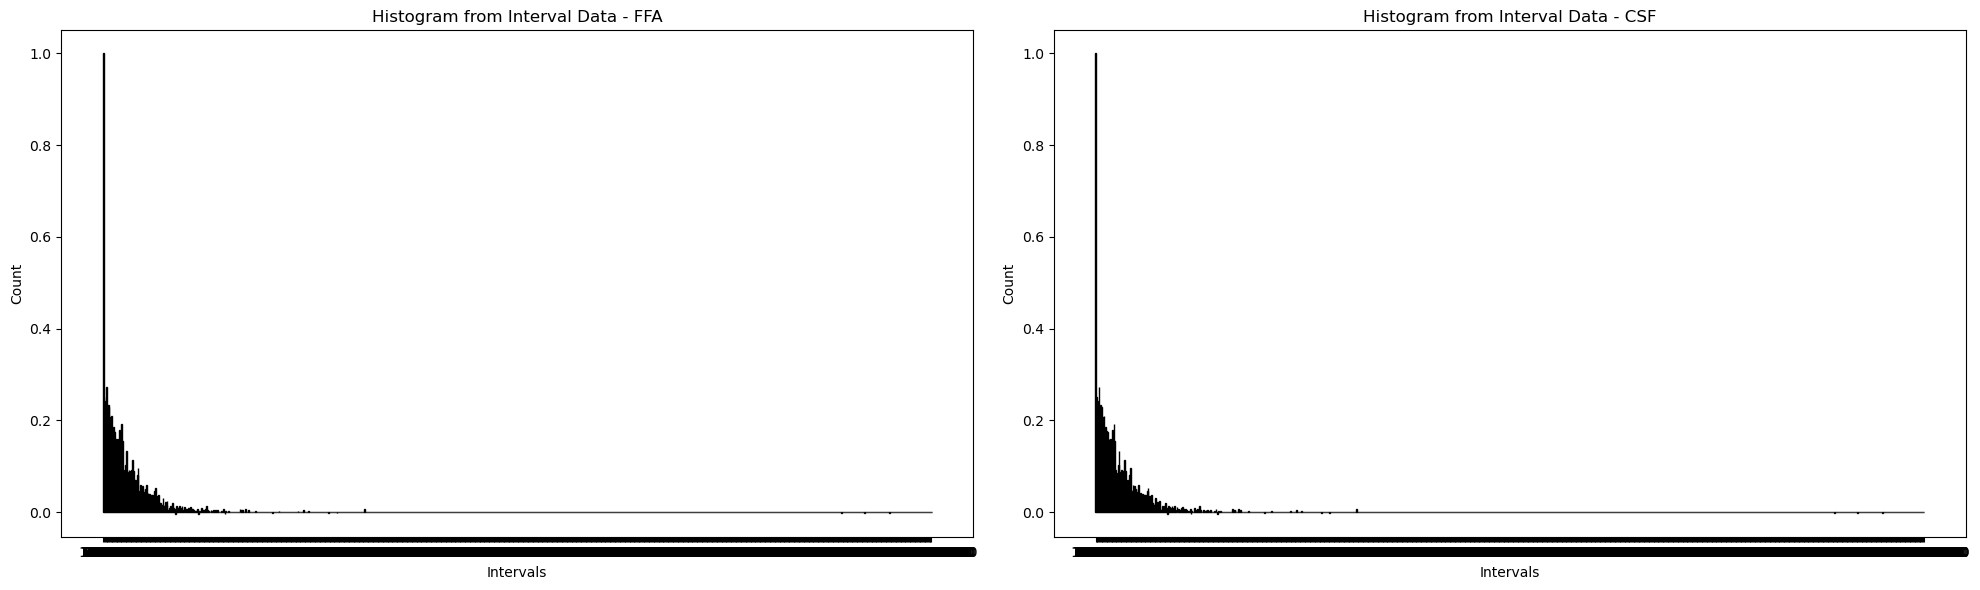

In [87]:
compute("util_3_9")

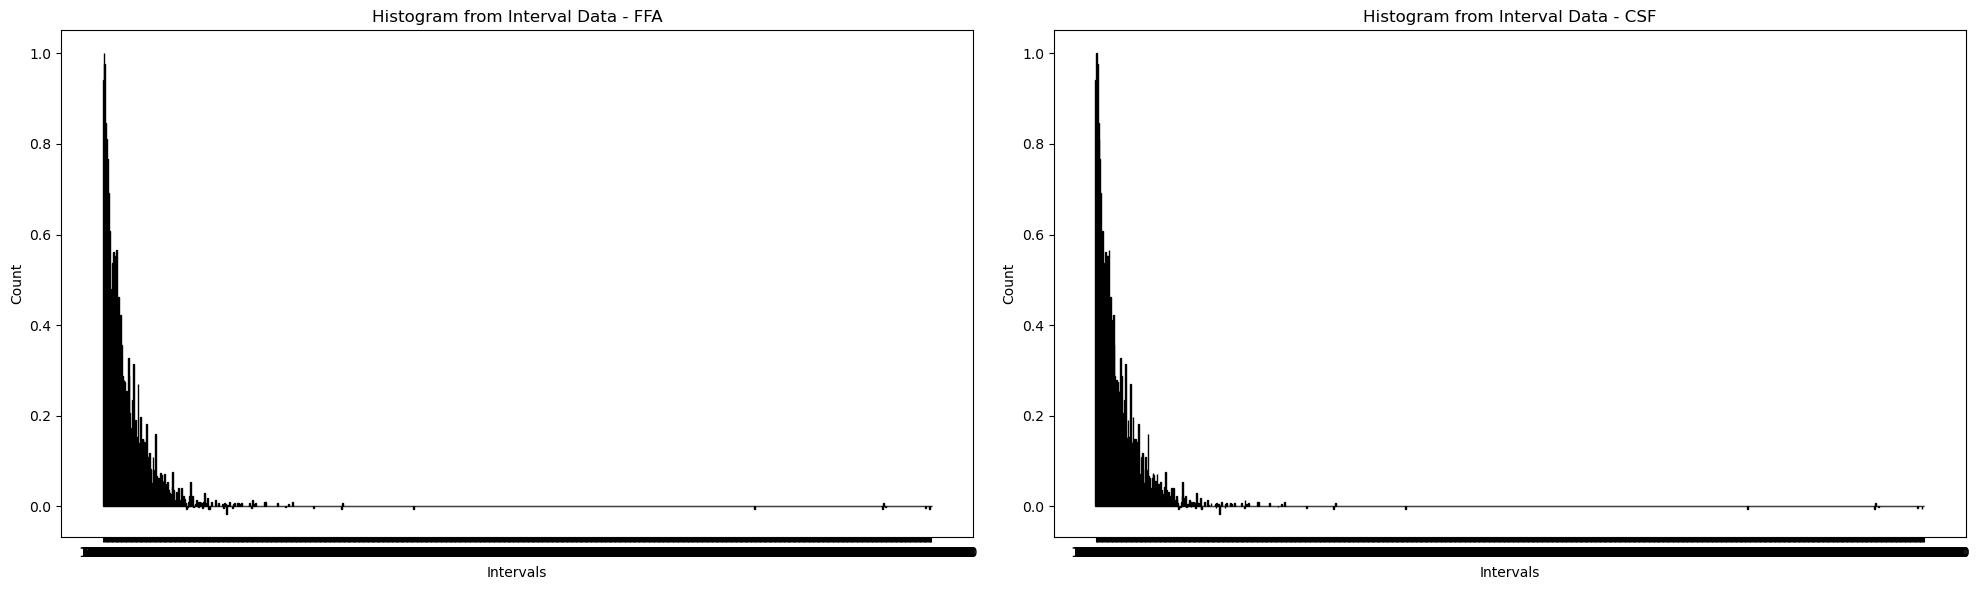

In [91]:
compute("util_4_0", "no_delay")

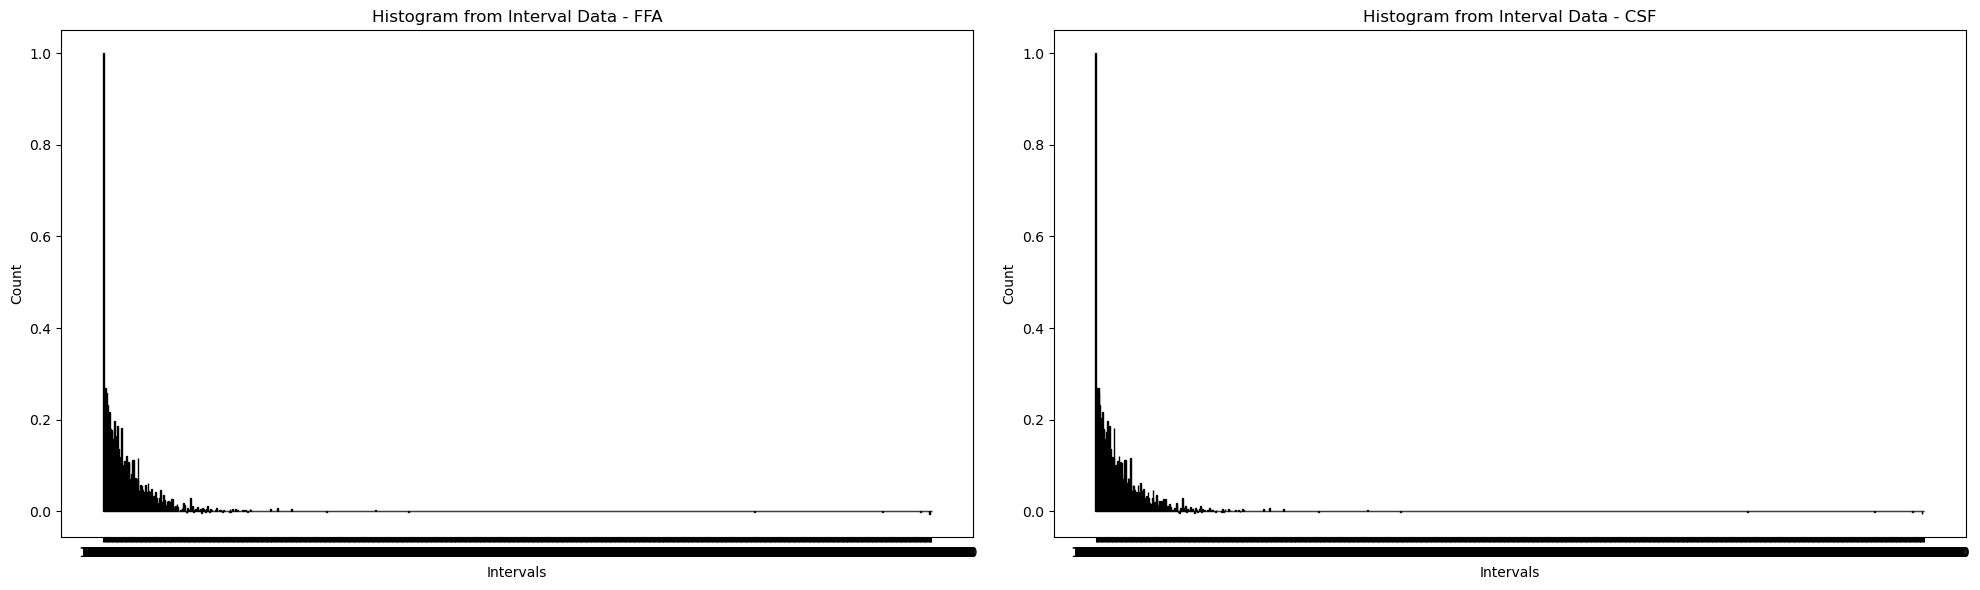

In [92]:
compute("util_4_0", "delay")

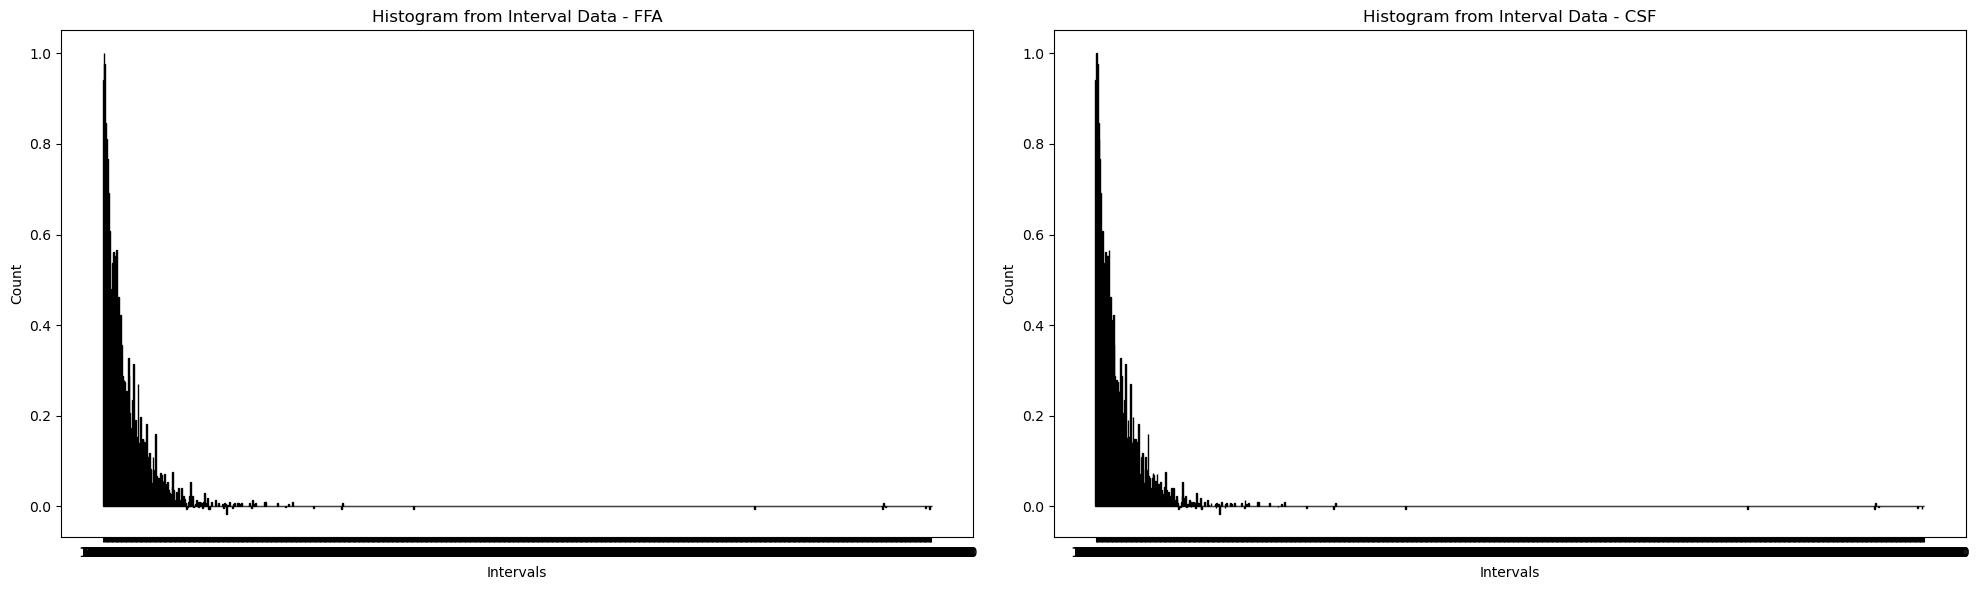

In [5]:
compute("util_4_0", "no_delay")